# Table of contents
1. [What would you find in this project?](#Whatwouldyoufindinthisproject?)
2. [Exploratory Data Analysis](#ExploratoryDataAnalysis)
    1. [Import data](#Importdata)
    2. [A First round of feature engineering](#FFE)
    3. [EDA for categorical features](#EDAC)
    4. [EDA for numerical features](#EDAN)
    5. [Check if holidays and events have an effect on sales](#holidays)
    6. [Check if the weekday has an effect on sales](#date)
    7. [Summary of EDA](#SUMMARY)
3. [Machine Learning](#ML)
    1. [Performance Metrics](#METRIC)
    2. [Split in training and test dataset. Compare both](#SPLIT)
    3. [Models](#Models)
        1. [Sarimax](#SARIMAX)
        2. [Prophet by Facebook](#PROPHET)
        3. [Xgboost](#XGBoost)
        4. [Model comparison](#COMPARISON)
4. [Production](#PRODUCTION)


<a id='Whatwouldyoufindinthisproject?'></a>
# What would you find in this project?

The purpose of this project is to deal with a **real world forecasting problem** and approach it with a **business concern**: from explaining the insights we can get just from the data, find a ML model that would fit on the forecasting problem and finally put into production the model and the insights we can get from it.

For this project I've chosen [this](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview) Kaggle dataset. This dataset contains information about the sales of multiple stores of the company Favorita, in Ecuador. The goal of this project is to find a model that able to **predict the estimation of sales** for each family group of products and stores. Predicting the sales of an element (in this case a product) gives to any business and important and powerful information to take advantage on. In the case of the stores, one of these huge advantages could be able to **estimate future revenue**, **allocate resources more effectively**, etc. [Here](https://www.getweflow.com/blog/importance-of-sales-forecasting) for more information.

So, in the following sections we will put ourselves in the shoes of a real store company, which want to understand which useful insights we can get from their historical data, train a model able to predict the future amount of sales and take advantage of this to increase the turnover.

<a id='ExploratoryDataAnalysis'></a>
# Exploratory Data Analysis

In any ML project, the [first step](https://www.bitstrapped.com/blog/exploratory-data-analysis-accelerates-machine-learning) should be done an exploratory data analysis, not only because doing this will help us to understand better the data we're working with, but also let us know if there are problems in the data we're working on prior trying to model it, let us know that the model we've trained is reliable and finally is a first step to bring useful insights without even have to train a model.

<a id='Importdata'></a>
## Import data

First of all, we'll import (and install) all necessary libraries we'll need in this notebook.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.stats as stats
from sklearn.model_selection import train_test_split, KFold, cross_val_score,  GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_log_error, make_scorer
import pmdarima as pm
from pmdarima.arima import ADFTest
from prophet import Prophet
from xgboost import XGBRegressor
import xgboost as xgb
from math import sqrt
from datetime import datetime, timedelta, date
import pickle
import logging
logging.getLogger("cmdstanpy").disabled = True #  turn 'cmdstanpy' logs off
import warnings
warnings.filterwarnings('ignore')

C:\Users\rojol\anaconda3\envs\time_series\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Now, we can import the data and take a look to the first rows:

In [10]:
train = pd.read_csv('train.csv')
holidays_events_df = pd.read_csv('holidays_events.csv')
oil_df = pd.read_csv('oil.csv')
stores_df = pd.read_csv('stores.csv')
test = pd.read_csv('test.csv')

train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


Let's take a look to the columns of the train dataset:

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In this project we have **several sources of information** that can be decisive to predict the sales of the Favorita supermarkets. In particular, we have the price daily oil price, which the kaggle project explains: "Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices", so could be interesting to add this information to the training set. On the other hand, we also have the national, regional and local events and public holidays, which are an important information to take into account in any forecasting model.

So, for the above reasons, we'll join all this information into a single dataframe in order to manage all the features in an easier way.

Anyway, we'll also study the effect of these features in the sales feature in order to know if it's a good idea to pick all these features to train the forecasting models.

<a id='FFE'></a>
## A First round of feature engineering 

In the following function, you can see how the dataframes with information about daily oil price, information about stores of Favorita company and the holidays and event dataframes are joined into the dataset of the daily sales for Favorita. Also, additional columns related with the date are added, as day of the week, day of the month, number of week and the number of month:

In [12]:
def join_multiple_df_sales(main_df, oil_df, stores_df, holidays_events_df):
    # Make copies to not modify original inputs
    oil_tmp = oil_df.copy(deep=True)
    stores_tmp = stores_df.copy(deep=True)
    holidays_events_tmp = holidays_events_df.copy(deep=True)
    train_df_merge = main_df.copy(deep=True)
    
    # Convert from object to datetime 'date' column
    train_df_merge['date']= pd.to_datetime(train_df_merge['date'])

    ## Merge with oil dataframe
    oil_tmp['date']= pd.to_datetime(oil_tmp['date'])
    # Fill null values for oil    
    oil_tmp.index = oil_tmp['date']
    oil_tmp.drop(columns=['date'], inplace=True)
    oil_tmp = oil_tmp.asfreq('D')
    oil_tmp.interpolate(inplace=True)
    # First value is null
    oil_tmp.iloc[0]=oil_tmp.iloc[1]
    train_df_merge = train_df_merge.merge(oil_tmp, left_on = 'date', right_index=True,  how='left')
    
    ## Merge with store dataframe
    train_df_merge = train_df_merge.merge(stores_tmp, left_on = 'store_nbr', right_on='store_nbr',  how='left')
    
    ## Merge and process with holidays_events dataframe
    holidays_events_tmp['date']= pd.to_datetime(holidays_events_tmp['date'])
    # Local events and holidays
    local_holidays = holidays_events_tmp[(holidays_events_tmp.locale == 'Local')][['date','locale_name']].rename(columns={"locale_name": "is_local_hol_or_eve"}).drop_duplicates()
    train_df_merge = train_df_merge.merge(local_holidays, left_on = ['date','city'], right_on=['date','is_local_hol_or_eve'],  how='left')
    # Regional events and holidays
    regional_holidays = holidays_events_tmp[(holidays_events_tmp.locale == 'Regional')][['date','locale_name']].rename(columns={"locale_name": "is_regional_hol_or_eve"}).drop_duplicates()
    train_df_merge = train_df_merge.merge(regional_holidays, left_on = ['date','state'], right_on=['date','is_regional_hol_or_eve'],  how='left')    # National events and holidays
    # National events and holidays
    national_holidays = holidays_events_tmp[(holidays_events_tmp.locale == 'National')][['date','locale_name']].rename(columns={"locale_name": "is_national_hol_or_eve"}).drop_duplicates()
    train_df_merge = train_df_merge.merge(national_holidays, left_on = ['date'], right_on=['date'],  how='left')
    # Cast to boolean columns
    train_df_merge.is_local_hol_or_eve = train_df_merge.is_local_hol_or_eve.notnull().astype(int)
    train_df_merge.is_regional_hol_or_eve = train_df_merge.is_regional_hol_or_eve.notnull().astype(int)
    train_df_merge.is_national_hol_or_eve = train_df_merge.is_national_hol_or_eve.notnull().astype(int)

    # Add additional date features.
    train_df_merge['day_of_week'] = train_df_merge['date'].dt.dayofweek
    train_df_merge['day_of_month'] = train_df_merge['date'].dt.day
    train_df_merge['month'] = train_df_merge['date'].dt.month
    train_df_merge['week'] = train_df_merge['date'].dt.week
    
    return train_df_merge

Below you can see the first rows of the train dataset merged with the other useful datasets:

In [13]:
train_df = join_multiple_df_sales(train, oil_df, stores_df, holidays_events_df)
test_df = join_multiple_df_sales(test, oil_df, stores_df, holidays_events_df)
train_df.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type,cluster,is_local_hol_or_eve,is_regional_hol_or_eve,is_national_hol_or_eve,day_of_week,day_of_month,month,week
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,Quito,Pichincha,D,13,0,0,1,1,1,1,1
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14,Quito,Pichincha,D,13,0,0,1,1,1,1,1
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14,Quito,Pichincha,D,13,0,0,1,1,1,1,1
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14,Quito,Pichincha,D,13,0,0,1,1,1,1,1
4,4,2013-01-01,1,BOOKS,0.0,0,93.14,Quito,Pichincha,D,13,0,0,1,1,1,1,1


<a id='null'></a>
## Check for nulls or duplicated data


Another important thing is to check how many null data we have on the dataset. In case we only have a few nulls or to much nulls, we just can delete those records/feature, but otherwise we'll have to infer the missing data. Here you can see all the features with the total of null values:


In [145]:
train_df.isna().sum()

id                        0
date                      0
store_nbr                 0
family                    0
sales                     0
onpromotion               0
dcoilwtico                0
city                      0
state                     0
type                      0
cluster                   0
is_local_hol_or_eve       0
is_regional_hol_or_eve    0
is_national_hol_or_eve    0
day_of_week               0
day_of_month              0
month                     0
week                      0
dtype: int64

We've been lucky and there is no null data in our data. Let's check if there are any duplicated rows in our data, otherwise if we keep duplicated data in our data we could add bias in training data or inflate the apparent performance of your model during evaluation:

In [144]:
train_df.duplicated().any()

False

As we can see above, there are no duplicated rows.

<a id='EDAC'></a>
## Exploratory Data Analysis of Sales for categorical features

In this section we'll study the categorical features and the relation with the target feature Sales a to get some useful insights. We'll use the same custom function to plot all categorical features:

In [112]:
# Function to get top N values of sales for a feature
def agg_top_n_values(df, feature, metric = 'sales', top_values=10,  ascending = False):
    # Group by dataframe
    groupby_feature = df.groupby(feature)[[metric]].sum()
    
    # Sort values decreasing
    category_counts = groupby_feature.sort_values(by = metric, ascending = ascending)

    #Check if there are more than top_values categories. If so, aggregate the rest in 'OTHER' category
    if len(category_counts.index) > top_values:
        # Take the top n categories
        top_categories = category_counts.head(top_values)

        # Group other categories into a new 'Other' category and put in a new dataframe
        other_category_count = pd.DataFrame([[category_counts[top_values:].sum().item()]], index=['OTHER'],columns=[metric])
    
        # Concatenate top categories and 'Other'
        final_category_counts = pd.concat([top_categories, other_category_count], ignore_index=False)
    
        return final_category_counts
    else:
        return category_counts

# Fucntion that plots a pie
def plot_pie_top_n_feature(df, feature, metric = 'sales', top_values=10):
    # Aggregate dataframe in top 10 items and the rest in OTHER category
    final_category_counts = agg_top_n_values(df, feature, metric, top_values)

    #Define color palette
    colors = sns.color_palette('colorblind')
    
    # Plotting the pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(final_category_counts[metric], labels=final_category_counts.index, autopct='%1.1f%%', pctdistance=0.8, startangle=0,labeldistance=1.155, wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white' }, colors=colors)
    plt.title('Top {0} {1} values for {2} metric'.format(top_values, feature, metric), fontsize = 13)
    plt.show()

# Function that plots a time series by differents values of a feature
def plot_monthly_time_series_hue_top_n_feature(dataframe, feature, time_feature = 'date', metric = 'sales', top_values = 10):
    # Filter columns
    df_tmp = dataframe[[time_feature, feature, metric]]
    df_tmp.set_index(time_feature, inplace=True)

    # Aggregate data for feature and in monthly data
    df_tmp = df_tmp.groupby([pd.Grouper(freq='M'), feature]).sum().reset_index()

    # Get top n family products
    df_top_n_values_features = agg_top_n_values(dataframe, feature, metric, top_values)
    list_top_n_values_features = df_top_n_values_features.index.get_level_values(0).unique()

    # Filter dataframe with top 10 family products
    df_top_n_values_features_w_time_metric = df_tmp[df_tmp[feature].isin(list_top_n_values_features)]

    # Line plot
    plt.figure(figsize=(15,8))
    color_palette = sns.husl_palette(top_values)
    ax = sns.lineplot(x=time_feature, y=metric, hue=feature, data=df_top_n_values_features_w_time_metric, palette=color_palette)
    ax.set_xlim(df_top_n_values_features_w_time_metric['date'].min(), df_top_n_values_features_w_time_metric['date'].max())
    plt.title('Top {0} of {1} feature by monthly {2}'.format(top_values, feature, metric), fontsize = 15)

<a id='family'></a>
### Analysis Family feature
The family feature identifies the type of product sold. Let's check which are the families of products top sold and how the sales of these products have evolved through the years.

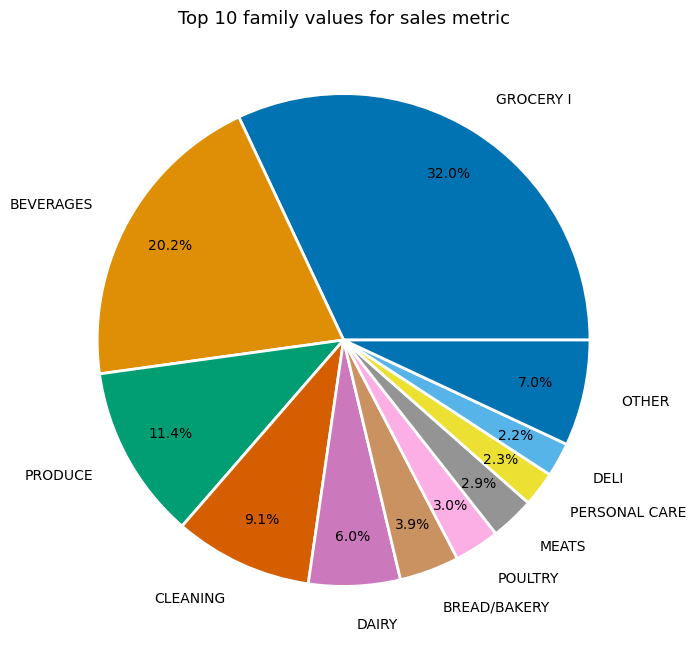

In [113]:
plot_pie_top_n_feature(train_df, 'family')

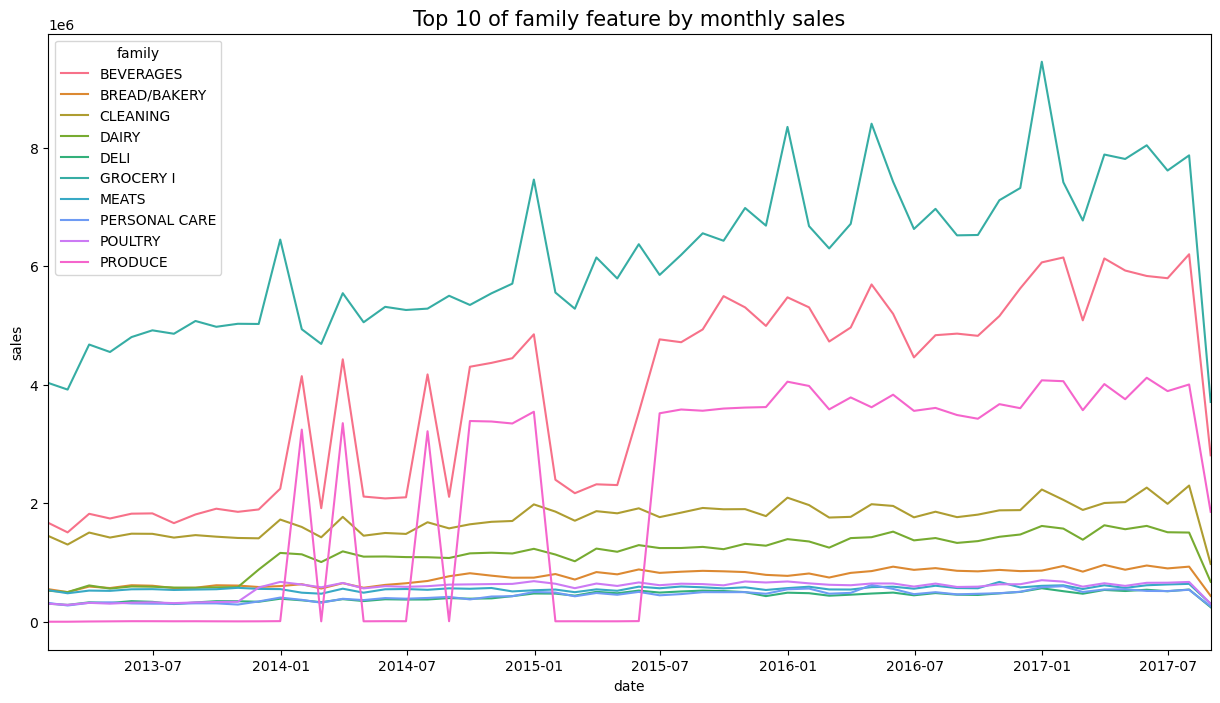

In [114]:
plot_monthly_time_series_hue_top_n_feature(train_df, 'family')

From the two plots we can see above, we can say the following:
- The top two family products more sold are: Grocery I and beverages. These two categories sum more than a 50% of the sales for the last years.
- Also, if we add the third and the forth categories sold: produce and cleaning, respectively, we almost have the 75% of the sales for the last years. So, **the top 4 category products make the 75% of the sales**, since 2013.
- Another interesting thing is that from the last 3 years until nowadays, produce has become the third category most sold. The order categories remain the same position of sales through all the years (since 2013).

<a id='cluster'></a>
### Analysis Store Feature
The store_nbr feature identifies the store at which the products are sold. Let's see if there are specific store more important than others in terms of sales.

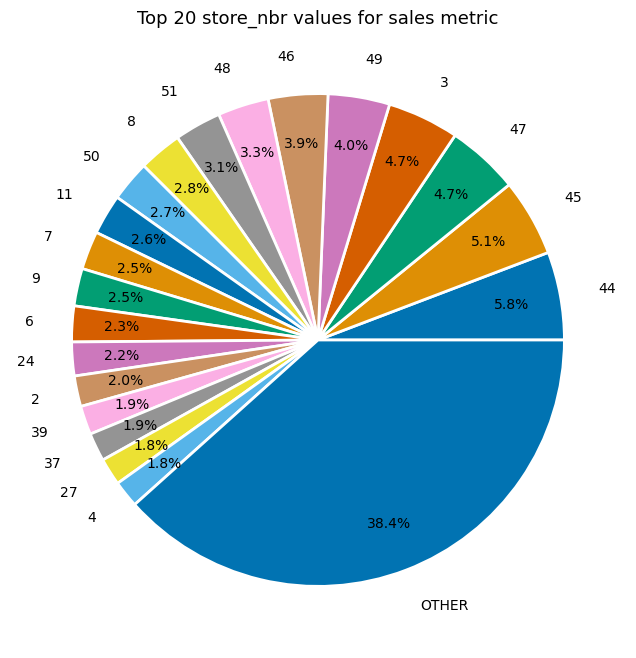

In [119]:
plot_pie_top_n_feature(train_df, 'store_nbr', 'sales', 20)

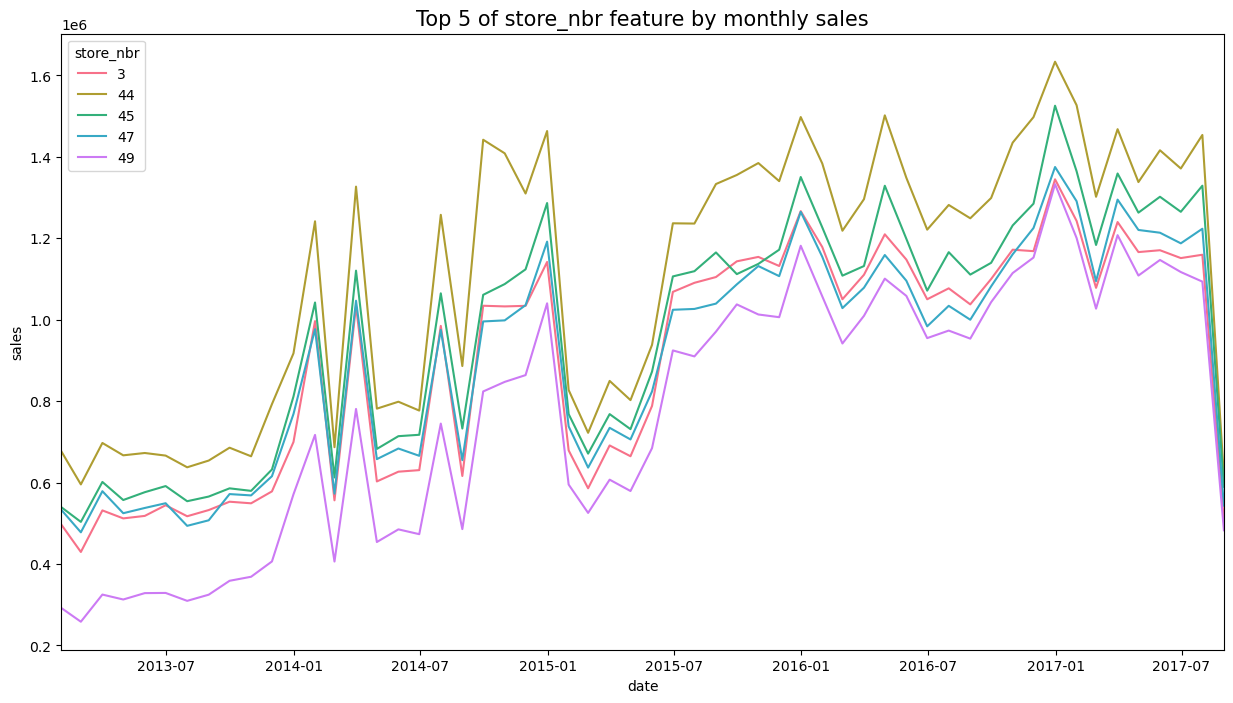

In [107]:
plot_monthly_time_series_hue_top_n_feature(train_df, 'store_nbr','date','sales',5)

From the first plot we can see that the top store in terms of sales is the 44 and has almost the 6%, and even its the first one there is not an exaggerated difference with the rest of the stores. With this we mean that **no one of the stores is the principal source of income of the company** and if one them would fail (even the 44) wouldn't result in the closure of the company because only would affect the 6% of the sales. Even though is clear that depends on the store our model would predict different amount of sales.

On the other hand, from the second plot we can say that there has been a **growth in sales in the last few years**.

<a id='state'></a>
### Analysis State Feature
The state feature is a metadata that identifies the ecuatiorian state where the stores are located.

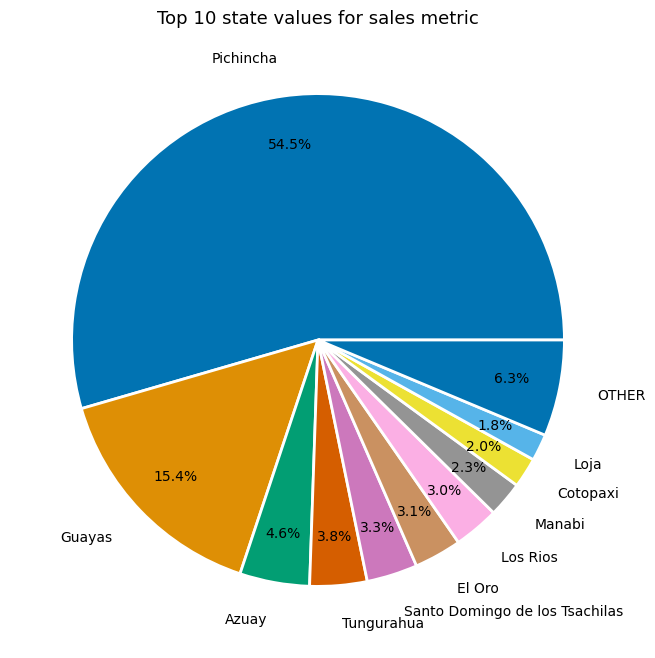

In [154]:
plot_pie_top_n_feature(train_df, 'state')

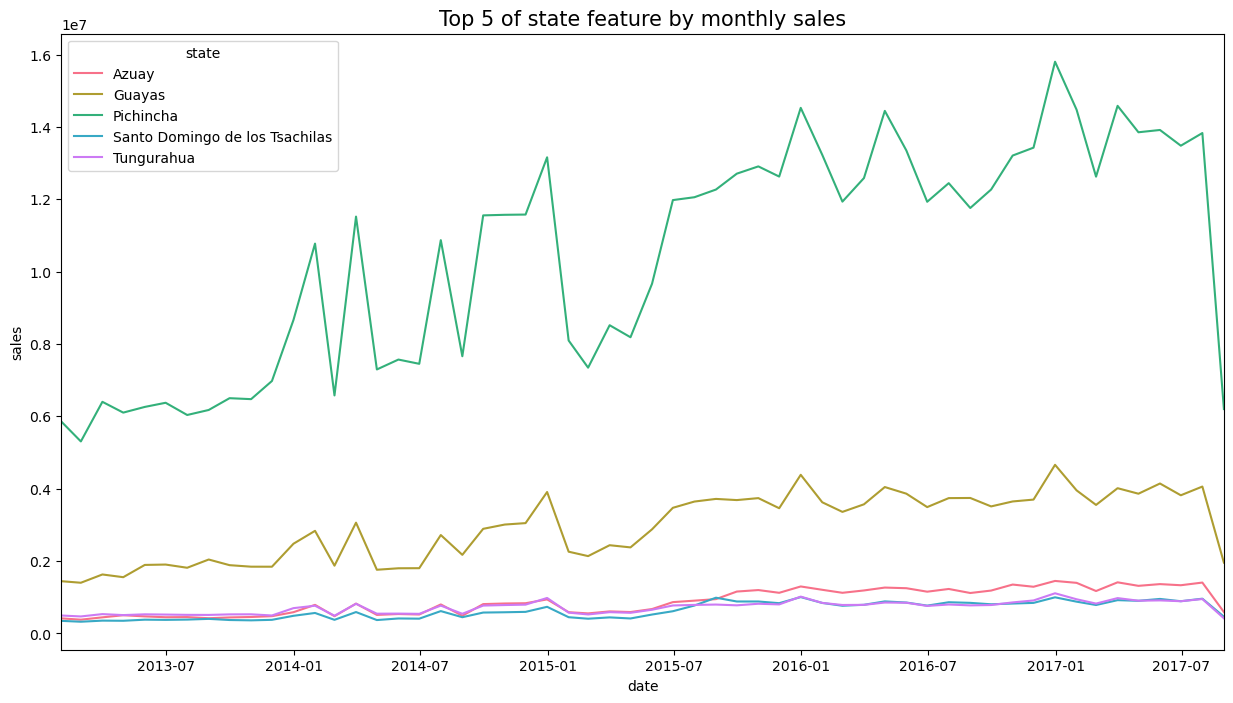

In [110]:
plot_monthly_time_series_hue_top_n_feature(train_df, 'state','date','sales',5)

From the two plots we can see above, we can say the following:
- The top state with more sales is: Pachincha. In this only state are made the 54.5% of sales. So we can say that for Favorita company this state has a lot of weight in their income. 
- Also, if we add the second and the third state: Guayas and Azuay, all of them sum more than the 75% of the sales. So, this top three states make the 75% of sales.

<a id='holidays'></a>
### Analysis Holidays Features
In this section we want to discover if holidays and events have an effect on sales. To do so, we'll compare the distribution and the principal statistics of the sales for those days that are holidays and for those that aren't. To do so, we've built a function that plot a boxplot and show principal statistical metrics:

In [135]:
def compare_main_stadistical_metrics(**lists):
    df_template = pd.DataFrame(columns=['count', 'std', 'min','mean','percentil 50', 'percentil 90', 'percentil 95','percentil 99', 'max'])
    df = df_template.copy()

    elements = len(lists)
    nrows = elements//2
    if elements%2 != 0:
        nrows +=1
    fig, axes = plt.subplots(nrows = nrows, ncols = 2, figsize=(10,10))
    i = 0
    for list_name, list in lists.items():
        df.loc[list_name] = [list.count().item(), list.std().item(), list.min().item(), list.mean().item(), list.quantile(0.5).item(), list.quantile(0.9).item(), list.quantile(0.95).item(), list.quantile(0.99).item(), list.max().item()]
        ax = sns.boxplot(data=list, ax=axes.flatten()[i])
        i+=1
    plt.show()
    return df


Now, we want to make subsets of data for those days that are holidays and for those that aren't holidays as you can see below:

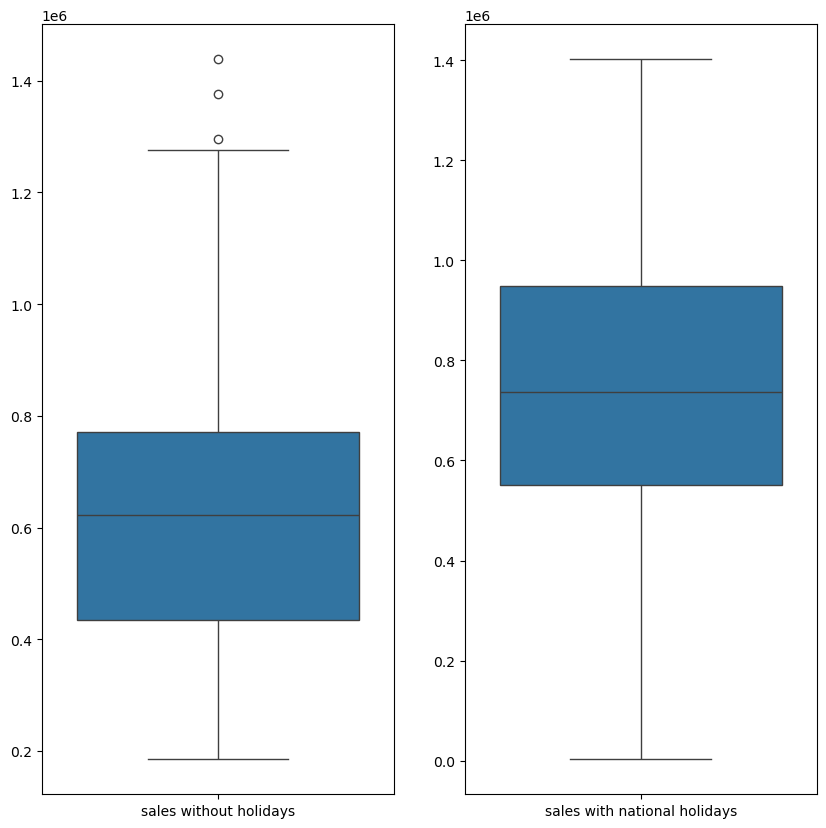

,count,std,min,mean,percentil 50,percentil 90,percentil 95,percentil 99,max
sales_without_any_holiday,1541.0,226668.778251,185222.899016,625043.604085,622771.923903,9.356560e+05,1.039418e+06,1.185140e+06,1.438311e+06
sales_with_national_holiday,143.0,286172.032538,2511.618999,735212.394940,737819.484836,1.087337e+06,1.194662e+06,1.329448e+06,1.402306e+06


In [136]:
sales_without_any_holiday = train_df[(train_df.is_local_hol_or_eve == 0) & (train_df.is_regional_hol_or_eve == 0) & (train_df.is_national_hol_or_eve == 0)][['sales','date']].groupby('date')[['sales']].sum().rename(columns={"sales": "sales without holidays"})
sales_with_national_holiday = train_df[(train_df.is_national_hol_or_eve == 1)][['sales','date']].groupby('date')[['sales']].sum().rename(columns={"sales": "sales with national holidays"})
compare_main_stadistical_metrics(sales_without_any_holiday=sales_without_any_holiday, sales_with_national_holiday=sales_with_national_holiday)                      

The first thing we can note is that the boxplot are noticeably different. The median from the boxplot sales without holidays is lower than the percentile 25 of the sales with national holidays and the median of the sales for national days is greater than percentile 75 for regular days, so just with this information we can guess that **holidays have a positive effect on sales**. To confirm that effect, we'll perform a t-test on the sales for holidays and for regular days. The T-test will confirm us if there is a significant difference between the mean of the two sets of sales:

In [134]:
# Generate sample data for regular days and holiday sales
np.random.seed(42)  # for reproducibility
regular_days_sales = sales_without_any_holiday
holiday_sales = sales_with_national_holiday

# Perform independent samples t-test
t_statistic, p_value = stats.ttest_ind(regular_days_sales, holiday_sales, equal_var = False)

# Output the results
print(f'T-Statistic: {t_statistic}')
print(f'P-Value: {p_value}')

# Compare p-value to significance level (e.g., 0.05)
alpha = 0.05
if p_value < alpha:
    print('Reject the null hypothesis: There is a significant difference in sales.')
else:
    print('Fail to reject the null hypothesis: There is no significant difference in sales.')

T-Statistic: [-4.47519228]
P-Value: [1.44864315e-05]
Reject the null hypothesis: There is a significant difference in sales.


So, as we guessed earlier, there is a significant difference in sales for those days that are holidays and those days that are regular, for that reason, we should take into account the holidays days in our model.

<a id='date'></a>
### Analysis Date Features
In this section we want to discover if the week date has an effect on sales. To do so, we'll compare the distribution and the principal statistics of the sales all the week days. To do so, we'll use the same function used in the previous section:

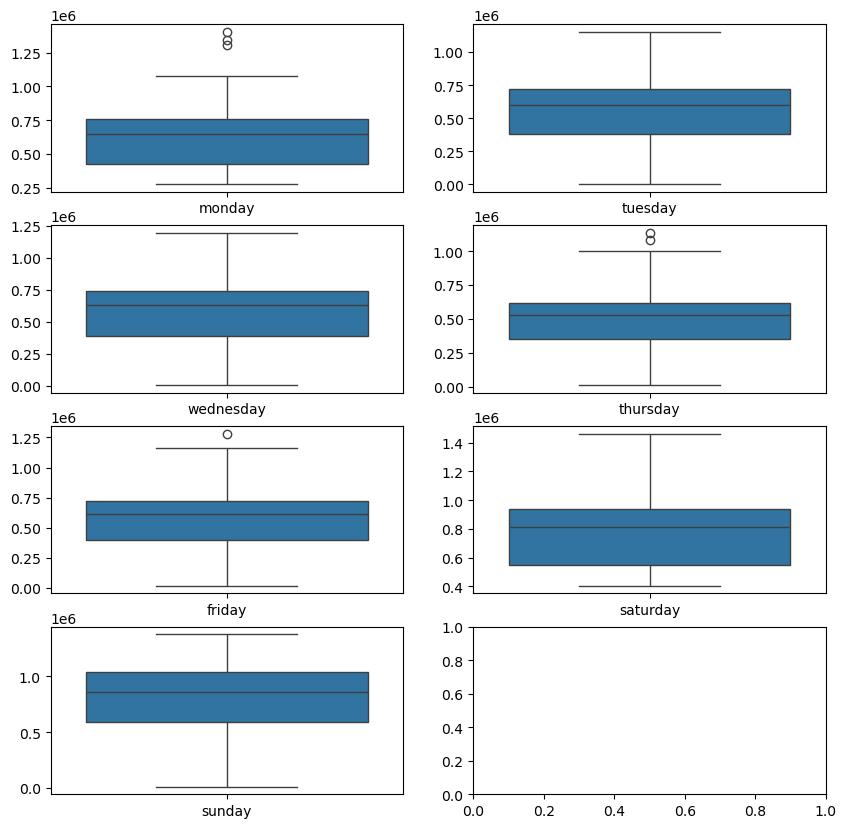

,count,std,min,mean,percentil 50,percentil 90,percentil 95,percentil 99,max
monday_sales,241.0,202901.445868,278627.588926,617542.713052,651800.509461,8.223347e+05,8.968249e+05,1.213175e+06,1.402306e+06
tuesday_sales,242.0,199672.002474,2511.618999,569926.087922,602440.102498,7.917177e+05,9.061189e+05,1.094547e+06,1.152089e+06
wednesday_sales,240.0,206976.013112,8602.065404,593244.553472,632951.683756,8.415648e+05,8.878679e+05,1.049797e+06,1.196146e+06
thursday_sales,240.0,168677.994700,12773.616980,505269.201115,531402.203129,6.949932e+05,7.673973e+05,9.868689e+05,1.135849e+06
friday_sales,240.0,191907.914811,16433.394000,579574.361085,616645.013015,8.172151e+05,8.571297e+05,9.589227e+05,1.282146e+06
saturday_sales,241.0,221747.538455,403258.212011,772205.593943,816064.644983,1.052868e+06,1.103806e+06,1.196268e+06,1.463084e+06
sunday_sales,240.0,257472.920530,12082.500997,825218.121579,862268.400242,1.140642e+06,1.202526e+06,1.274494e+06,1.376512e+06


In [68]:
monday_sales = train_df[train_df['date'].dt.dayofweek == 0].groupby(by=["date"]).sum()['sales'].to_frame().rename(columns={"sales": "monday"})
tuesday_sales = train_df[train_df['date'].dt.dayofweek == 1].groupby(by=["date"]).sum()['sales'].to_frame().rename(columns={"sales": "tuesday"})
wednesday_sales = train_df[train_df['date'].dt.dayofweek == 2].groupby(by=["date"]).sum()['sales'].to_frame().rename(columns={"sales": "wednesday"})
thursday_sales = train_df[train_df['date'].dt.dayofweek == 3].groupby(by=["date"]).sum()['sales'].to_frame().rename(columns={"sales": "thursday"})
friday_sales = train_df[train_df['date'].dt.dayofweek == 4].groupby(by=["date"]).sum()['sales'].to_frame().rename(columns={"sales": "friday"})
saturday_sales = train_df[train_df['date'].dt.dayofweek == 5].groupby(by=["date"]).sum()['sales'].to_frame().rename(columns={"sales": "saturday"})
sunday_sales = train_df[train_df['date'].dt.dayofweek == 6].groupby(by=["date"]).sum()['sales'].to_frame().rename(columns={"sales": "sunday"})
compare_main_stadistical_metrics(monday_sales=monday_sales, tuesday_sales=tuesday_sales, wednesday_sales=wednesday_sales, thursday_sales=thursday_sales, friday_sales=friday_sales, saturday_sales=saturday_sales, sunday_sales=sunday_sales)

Again, we can notice a difference between the sale made during all the days of the week, especially for Thursdays (that is the day with less sales, 50K on average) and Sunday (that is the day with more sales, 85K on average). To confirm that the day of the week has an impact on the sales, let's perform again a T-test with the sales on Thursday and Sunday:

In [137]:
# Generate sample data for regular days and holiday sales
np.random.seed(42)  # for reproducibility

# Perform independent samples t-test
t_statistic, p_value = stats.ttest_ind(thursday_sales, sunday_sales, equal_var = False)

# Output the results
print(f'T-Statistic: {t_statistic}')
print(f'P-Value: {p_value}')

# Compare p-value to significance level (e.g., 0.05)
alpha = 0.05
if p_value < alpha:
    print('Reject the null hypothesis: There is a significant difference in sales.')
else:
    print('Fail to reject the null hypothesis: There is no significant difference in sales.')

T-Statistic: [-16.10308569]
P-Value: [1.30758191e-45]
Reject the null hypothesis: There is a significant difference in sales.


So, as we guessed earlier, there is a significant **difference in sales depend on the day of the week**, for that reason, we should take into account the week day in our model.

<a id='EDAN'></a>
## Exploratory Data Analysis of Sales for numerical features

Let's explore the two numerical features we have in this dataset: 
- **onpromotion**: the total number of items in a product family that were being promoted at a store at a given date.
- **dcoilwtico**: daily oil price

Because the feature dcoilwtico is given daily, we'll sum and aggregate sales and onpromotion features on a daily basis in order to compare with the same measure all these three features.

In [140]:
# Aggregate daily sales and onpromotion
groupby_date_sales_promotion = train_df.groupby('date')[['sales','onpromotion']].sum()

# Set datetime index to oil datarame
oil_df['date']= pd.to_datetime(oil_df['date'])
oil_df = oil_df.set_index('date')

# Join all features in same dataset
groupby_date_sales_promotion_oil = groupby_date_sales_promotion.merge(oil_df, left_index = True, right_on='date',  how='left')

Now that we have all data aggregated daily, let's compute the correlation to see the relationship between all these features. Because we're dealing with continous variable we'll use pearson correlation:

<Axes: >

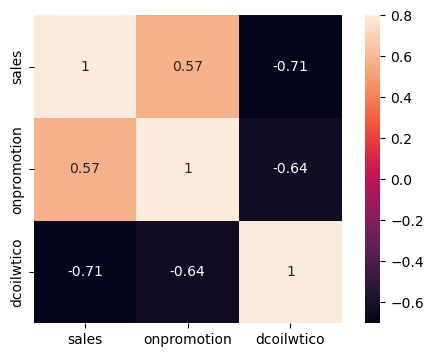

In [143]:
corrmat = groupby_date_sales_promotion_oil[['sales','onpromotion','dcoilwtico']].corr()
f, ax = plt.subplots(figsize=(6,4))
sns.heatmap(corrmat, vmax=.8, square=True,annot=True)

As we can see above, sales feature has a [high degree of correlation](https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/pearsons-correlation-coefficient/) with the price of oil and the number of items on promotion because both of them are greater than 0.5 (in absolute value). 

In the case of onpromotion feature, for greater values of this feature also we find high values for sales, which makes sense because if a store makes a deal or an offer of a product it is supposed to increase sales. 

On the other hand, for dcoiltwico feature, because presents a negative correlation, for greater values of oil, lower values of sales. This also makes sense, because for greater values of oil, the cost of living also increases (transportation cost increases the price of products) and that's why is reasonable that sales decreases.

These two features have an impact on our target feature sales, so we'll include them in the models.

<a id='trend'></a>
## Check trend and seasonality

In the case of forecasting is very important to know if data is stationary and which is the trend and the seasonality. It is important to know because depend on them, there will be models that wouldn't fit at all.

We're going to aggregate data daily because it would be easier to plot the time series and detect any pattern in data:

In [147]:
daily_sales = train_df.groupby('date')[['sales']].sum()
daily_sales.head()

,sales
date,
2013-01-01,2511.618999
2013-01-02,496092.417944
2013-01-03,361461.231124
2013-01-04,354459.677093
2013-01-05,477350.121229


The following function will help us to visualize the time series and the correlation with its lagged values (refers to the value of a variable at a previous time point), using the Autocorrelation plot and the partial autocorrelation plot. A strong correlation at a particular lag indicates that the series is correlated with itself at that lag, suggesting a potential pattern or dependency in the data.


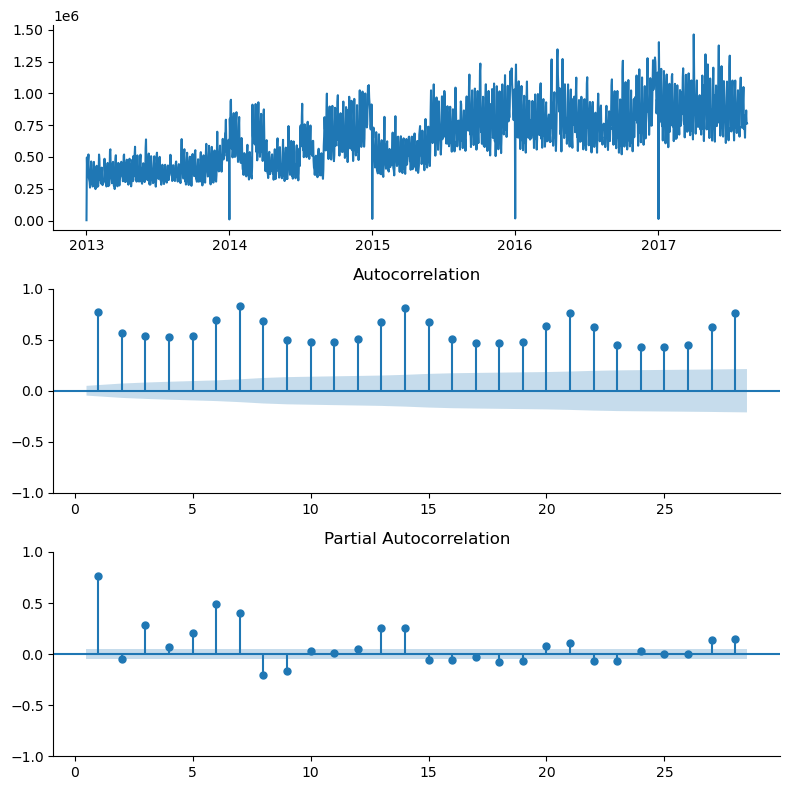

In [158]:
def plot_time_series_acf_pacf(data, lags=None):
    plt.figure(figsize=(8,8))
    layout = (3,1)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (1, 0))
    pacf = plt.subplot2grid(layout, (2, 0))
    
    raw.plot(data)
    plot_acf(data, lags=lags, ax=acf, zero=False)
    plot_pacf(data, lags=lags, ax=pacf, zero = False)
    sns.despine()
    plt.tight_layout()

plot_time_series_acf_pacf(daily_sales['sales'], lags = 28)

From the plot of the time series, we can say that a **linear positive trend** can be seen, with a multiplicative seasonal component (because seasonal fluctuations vary proportionally with the trend level). 
On the other hand, **weekly seasonality** can be appreciated with the correlation plots. For both of them, you can see peaks for lags multiples of 7.

Visually, it doesn't seem that time series is stationary, because the mean (and others statistical metrics) of the time series don't remain constant over time. Anyway, let's compute the ADF test to confirm it.

In [23]:
adf_test=ADFTest(alpha=0.05)
adf_test.should_diff(daily_sales)

(0.01, False)

The test confirm the non-stationary of the time series.

<a id='SUMMARY'></a>
## Summary EDA

In this section we've said many things about this dataset. Let's just summarize all above in the following take aways:
- The top 4 category products (grocery I, beverages, produce and cleaning) make the 75% of the sales  
- No one of the stores is the principal source of income of the company. The store with more sales only have the 6% of the generals sales.
- There are three states that makes the 75% of the sales. These states are: Pachincha, Guayas and Azuay
- Holidays have a positive effect on sales.
- The day of the week have and impact on the sales, especially for Thursdays (that is the day with less sales, 50K on average) and Sunday (that is the day with more sales, 85K on average)
- When there are products on promotion the sales increase.
- When the oil prices increases, the sales decreases.
- We've seen a linear positive trend in sales and a weekly seasonality.


<a id='ML'></a>
# Machine Learning

In the previous part of this project, we've had examined a dataset that describes the sales of different stores located in Ecuador. We explored and discovered interesting insights about the sales of the company and how the external factors can influence the sales of the company. Now, we're moving on to the Machine Learning part of this project.

Our main goal here is to find the best model that could accurately **predict the sales of each store and product of the company**. Also, in this section we'll clean and transform the data to ease that the data could fit in several models.


<a id='METRIC'></a>
## Performance Metric

For this forecasting problem we'll be using these following three performance metrics:

 - **MAE** (Mean absolute error). This metric is the average of absolute difference between forecasted values and true values. This metric is not sensitive to outliers.
 - **R2** (Coefficient of determination). This metric tries to measure how good or how bad is the model respect to a model that always returns the mean of the target. This metric is upper bounded by 1, and for R2 values near 1 it means that our model is far much better that the mean estimator. For values around 0, means that our model performs likewise the mean estimator. This metric is not lower bounded.
 - **RMSLE** (Root Mean Squared Logarithmic Error). Penalize underestimates more than overestimates. This is the metric that uses the Kaggle competition, so let's use it as well.

Another metric that would be interesting to use would be **MAPE** (Mean Absolute Percentage Error), which is the percentage of the average of absolute difference between forecasted values and true values, divided by true value. Because in our dataset there are a lots of zero values to forecast is not a good idea to use this metric in our case.
 
We'll be using both metrics to check how the trained models are performing.

<a id='SPLIT'></a>
## Split training and test data

For time series, data never should be shuffled and always we should take as validation/test data the last records of the series, in order to check if our model could properly forecast the next steps of the time series. 

Because the hardware resources for this project are limited, we'll be using either the last month or last year for historical data. We'll pick the last 15 days for testing purposes because in the kaggle competition this is the range to forecast.

In [14]:
# Split into training and testing
tmp = train_df[(train_df.date >= '2016-08-01')] # Filter last year of historical
# Set date as index
tmp.index = tmp.date
tmp.date.drop(columns=['date'], inplace=True)
# Define two differents training sets
df_train_year = tmp[(tmp.index >= '2016-08-01') & (tmp.index < '2017-08-01')]
df_train_month = tmp[(tmp.index >= '2017-07-01') & (tmp.index < '2017-08-01')]
# Define the test set
df_test = tmp[(tmp.index >= '2017-08-01')]

Also, let's create an empty dataframe where we'll store all the errors metrics of our models.

In [15]:
# Create empty DataFrame to store the performance metrics of each model
df_results = pd.DataFrame()

<a id='MODELS'></a>
## Models

In this section, we'll try to find a model able to predict the house price sale based on all the features. To do so, we'll use a hyperparameter tuning and a cross validation. 

<a id='SARIMAX'></a>
### SARIMAX 

Sarimax could be a good fit for our data because this model takes into account **seasonality components and also exogenous** (i.e. external) variables can be added to the model. 

Sarimax model is an extension of the classical Sarima model that also incorporates exogenous variables (external predictors that are independent of the model's own time series). So, to understand Sarimax, let's explain briefly the basics of Sarima.

**Sarima** comes from **Arima** model which is a compound of different models: AR (autoregression), I (integration), MA (moving average). Let's explain a little bit each one:

1. **AR**: models the linear relationship between the current observation and a number of $p$ lagged values. In simpler terms, captures the dependency between current values and its past values.
2. **I**: refers to the differencing process to make data stationary. The order of differencing is given by a parameter $d$ usually $\in \{0,1,2\}$. It means the number of times of differencing needed to make data stationary. Data is converted from non-stationary to stationary by subtracting previous observations.
3. **MA**: Models the relationship between current observation and its past $q$ errors in the forecast. It assumes that there is information left in the residuals that can be added into the model

To get an estimation for the p and q parameters, can be useful to take a look to the autocorrelation (ACF) and partial autocorrelation functions (PACF). To pick a p value get the peaks from PACF or the greatest value above the 0.95 confidence interval. To pick q, do the same but with the ACF.

The whole process for Arima would be like this:
1. Remove trend of the time series by differencing (**I**)
2. Apply **AR**: Build the linear forecast method with lagged values.
3. Apply **MA**:
    1. Find residuals/errors $y-\hat y$
    2. Build forecast model on residuals
    3. Update initial forecast with the forecasted residuals
4. De-differencing: adding back lagged values to our forecast (**I**)
    
Also, the "**S**" from Sarima indicates the "seasonal" part. The model accounts for recurring patterns, like monthly or yearly seasonality. This component is modeled by 4 parameters:
1. **P** (Seasonal AutoRegressive): Similar to p, but for seasonal effects. How many past seasonal values influence the forecast.
2. **D** (Seasonal Integrated): How many times to seasonally difference the data to remove seasonal trends.
3. **Q** (Seasonal Moving Average): How many past seasonal forecast errors are considered.
4. **m** (Seasonality): This defines the number of periods in a season. For monthly data, m=12.

Finally, for Sarimax model, the "**X**" comes from e**x**ogenous. SARIMAX allows for the inclusion of external variables (exogenous regressors) that can improve the model's forecasting performance. These variables are not directly influenced by the time series itself but may impact its behavior.

For hardware and time performance limitations, data must be partitioned and trained a separately different sarimax models for every partition. These partitions will be done with every combination of store number and family product.

In the next cell, you can see a train and a scoring function. In the training function a sarimax is trained for each combination of store and family product with the best hyperparameters in each partition. Because in the EDA section we've seen a weekly seasonality, we've set m = 7.

For the scoring function, MAE, R2 and RMSLE are calculated for each model and then a general MAE,R2 and RMSLE are calculated.

At first, we'll try to fit data with a monthly historical range.

In [16]:
def train_multiple_sarimax_models(df_train, file_to_store_models, exog_features = ['onpromotion', 'dcoilwtico','is_local_hol_or_eve','is_regional_hol_or_eve','is_national_hol_or_eve','day_of_week'], models_sarimax = {}):
    # Dict where we'll store all models: models_sarimax
    # Retrieve all stores and family groups products for which combinations we'll create a model
    store_list = df_train.store_nbr.sort_values().unique()
    family_group = df_train.family.sort_values().unique()
    cont = 0
    for store in store_list:
        for family in family_group:
            model = str(store) + "_" + family
            if model not in models_sarimax.keys():
                # Filter data to train model for specific store and family
                df_train_tmp = df_train[(df_train.store_nbr == store) & (df_train.family == family)]
                # Try ocsb value for seasonal_test by default. If fails use ch
                for seasonal_test in ['ocsb','ch']:
                    try:
                        # Get better ARIMA hiperparameters for this model
                        stepwise_model = pm.auto_arima(df_train_tmp['sales'], 
                                            exog=df_train_tmp[exog_features],
                                            start_p=0, max_p=3,
                                            start_q=0, max_q=3, 
                                            m=7, 
                                            seasonal=True,
                                            d=None,
                                            start_P=0, max_P=3, 
                                            start_Q=0, max_Q=3,
                                            max_D=2,
                                            trace=False,
                                            error_action='ignore', 
                                            seasonal_test= seasonal_test,
                                            suppress_warnings=True, 
                                            n_jobs = -1,
                                            stepwise=True)
                        order = stepwise_model.order
                        seasonal_order = stepwise_model.seasonal_order
                        # Train SARIMAX model with best hiperparameters found
                        sar = SARIMAX(df_train_tmp['sales'], 
                              exog=df_train_tmp[exog_features],
                                seasonal_order=seasonal_order).fit()
                        # Save model trained in dictionary
                        models_sarimax[model] = sar
                        # Serialize and write the variable to the file
                        with open(file_to_store_models, 'wb') as file:
                            pickle.dump(models_sarimax, file)      
                        break #if worked break seasonal_test loop             
                    except:
                       print('For {} store and {} family model, used ch as seasonal_test argument'.format(store,family))
                cont += 1
                if cont%100 == 0:
                    print(cont)     
    return models_sarimax
#https://stackoverflow.com/questions/71944110/max-lag-problem-using-auto-arima-function --> Why I use diffent values for seasonal_test 

def sarimax_metric_errors(models_sarimax, df_test, exog_features = ['onpromotion', 'dcoilwtico','is_local_hol_or_eve','is_regional_hol_or_eve','is_national_hol_or_eve','day_of_week']):
    # Initializate lists to store results
    forecast_values = pd.Series([])
    real_values = pd.Series([])
    r2_values = []
    mae_values = []
    models_name = []
    rmsle_values = []
    from sklearn.metrics import mean_squared_log_error
    
    store_list = df_test.store_nbr.sort_values().unique()
    family_group = df_test.family.sort_values().unique()
    for store in store_list:
        for family in family_group:
            model = str(store) + "_" + family
            if model in models_sarimax.keys():
                df_test_tmp = df_test[(df_test.store_nbr == store) & (df_test.family == family)]
                forecast = models_sarimax[model].get_forecast(steps=15, exog=df_test_tmp[exog_features])
                future_predicted_values = forecast.predicted_mean
                actual_values = df_test_tmp['sales']

                # Append all forecast and real values for general metric errors
                forecast_values = forecast_values.append(future_predicted_values)
                real_values = real_values.append(actual_values)
        
                # Calculate error metrics for each specific model
                models_name.append(model)
                r2_scr = r2_score(actual_values,future_predicted_values)
                # Because r2 is not lower bounded, for visualizig purposes set 0 all those negative r2 scores.
                if r2_scr <= 0:
                    r2_scr = 0
                r2_values.append(r2_scr)
                mae_values.append(mean_absolute_error(actual_values,future_predicted_values))
                future_predicted_values = [0 if i < 0 else i for i in future_predicted_values]  #Mean Squared Logarithmic Error cannot be used when targets contain negative values.
                rmsle_values.append(sqrt(mean_squared_log_error(actual_values,future_predicted_values)))

    # Save in a dataframe the performance metric for each model
    data = {
        'r2': r2_values,
        'mae': mae_values,
        'rmsle': rmsle_values
    }
    df = pd.DataFrame(data, index=models_name)
    # create histogram with a different y scale for different rows
    selection = ['r2', 'mae','rmsle']
    fig, axes = plt.subplots(nrows=1, ncols=3,  figsize=(14,4))
    for i, col in enumerate(selection):
        ax = sns.histplot(data=df, x=col, ax=axes.flatten()[i], bins = 50)
        ax.set_ylabel('value')
        ax.set_xlabel(col)
    plt.show()

    # Compute general metrics performance 
    r2 = r2_score(real_values,forecast_values)
    print("\nGeneral value for R2 metric for all models is: " + str(r2))
    mae = mean_absolute_error(real_values,forecast_values)
    print("\nGeneral value for MAE metric for all models is:" + str(mae))
    forecast_values[forecast_values < 0] = 0  #Mean Squared Logarithmic Error cannot be used when targets contain negative values.
    rmsle = sqrt(mean_squared_log_error(real_values,forecast_values))
    print("\nGeneral value for RMSLE  metric for all models is:" + str(rmsle))

    return r2, mae, rmsle, df

<a id='SARIMAXMonth'></a>
#### Monthly historical data

Train the model or load trained model from disk.

In [17]:
%%time 
# 1h 10min
file_sarimax_month_path = 'sarima_month_trained.pickle'
# models_sarimax_month = train_multiple_sarimax_models(df_train_month, file_sarimax_month_path)
# If we've already trained the model and we want it to restore from file instead to retrain again.
with open(file_sarimax_month_path, 'rb') as file:
    # Deserialize and retrieve the variable from the file
    models_sarimax_month = pickle.load(file)

CPU times: total: 15.4 s
Wall time: 16.7 s


Let's see the performance metrics of all models trainned and the general performance metrics:

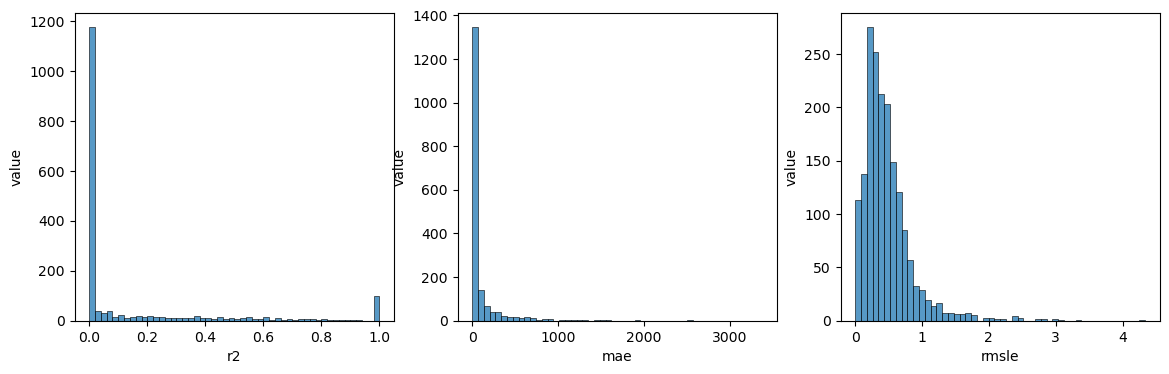


General value for R2 metric for all models is: 0.9093748919697401

General value for MAE metric for all models is:106.06005187095916

General value for RMSLE  metric for all models is:0.6215412629164062
CPU times: total: 24.6 s
Wall time: 24.9 s


In [18]:
%%time
r2_sarimax_month, mae_sarimax_month, rmsle_sarimax_month, all_models_metric_sarimax_month =  sarimax_metric_errors(models_sarimax_month, df_test)

In [19]:
new_row = pd.DataFrame({'MAE': [mae_sarimax_month], 'R2': [r2_sarimax_month], 'RMSLE': [rmsle_sarimax_month]}, index=['Sarimax trained month data'])
# Concatenate DataFrame with new row
df_results = pd.concat([df_results, new_row])

Let's see the prediction of one model that has a low value of MAE:

In [82]:
all_models_metric_sarimax_month[all_models_metric_sarimax_month.mae > 10].sort_values(by=['mae']).head(1)

,r2,mae,rmsle
28_HOME AND KITCHEN II,0.0,10.070439,1.043912


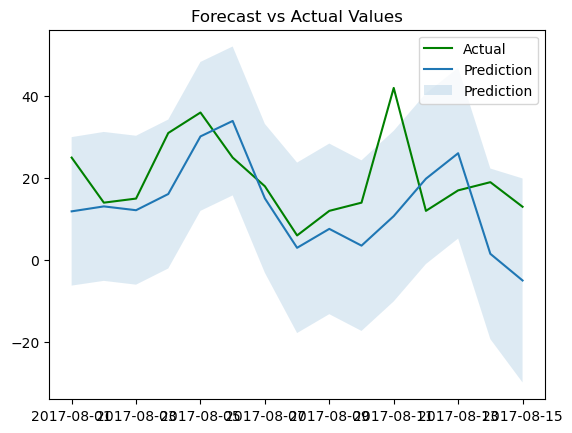


Diagnostics of model:



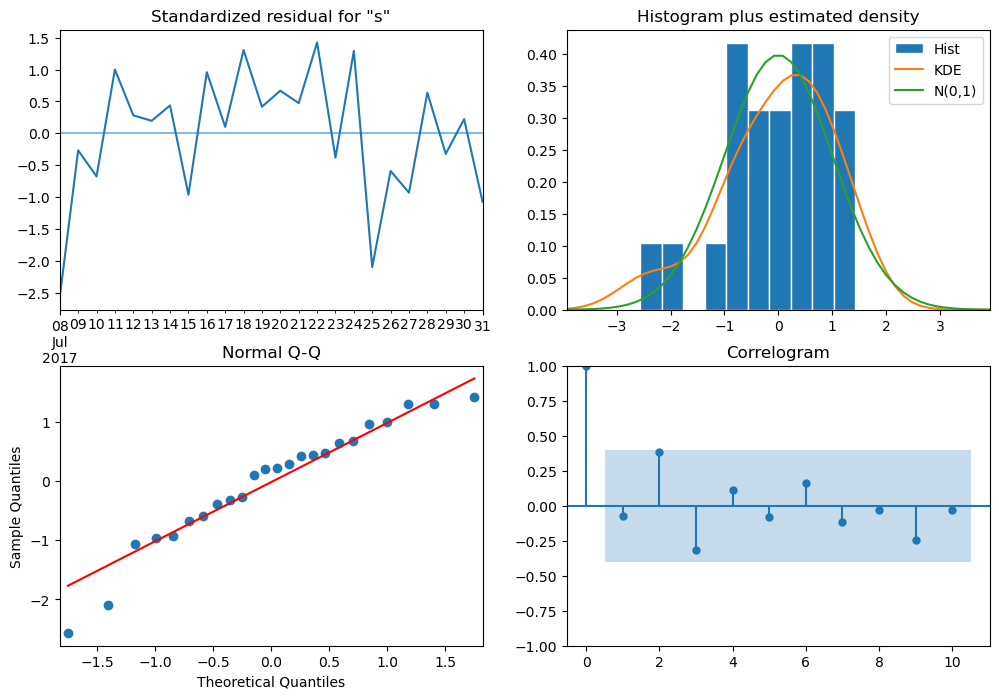

In [91]:
def plot_results_specific_sarimax_model(store_nbr, family):
    model_tmp = models_sarimax_month[str(store_nbr) + '_' + family]
    df_test_tmp = df_test[(df_test.store_nbr == store_nbr) & (df_test.family == family)]
    forecast_tmp = model_tmp.get_forecast(steps=15, exog=df_test_tmp[['onpromotion', 'dcoilwtico','is_local_hol_or_eve','is_regional_hol_or_eve','is_national_hol_or_eve','day_of_week']])
    future_predicted_values = forecast_tmp.predicted_mean
    confidence_intervals = forecast_tmp.conf_int()
    
    # Plot the actual sales and predicted values
    plt.plot(df_test_tmp['sales'], label = 'Actual', color = 'green')
    plt.plot(future_predicted_values.index, future_predicted_values, label='Prediction')
    plt.fill_between(future_predicted_values.index, 
                     confidence_intervals['lower sales'], 
                     confidence_intervals['upper sales'], 
                     label='Prediction',
                      alpha=0.15
                    )
    plt.title('Forecast vs Actual Values')
    plt.legend()
    plt.show()
    
    print('\nDiagnostics of model:\n')
    model_tmp.plot_diagnostics(figsize=(12, 8))
    plt.show()

store_nbr = 28
family = 'HOME AND KITCHEN II'
plot_results_specific_sarimax_model(store_nbr, family)

From this prediction, we can say the following:
- Although the prediction is not very accurate, is quite similar and all actual values lie on the confidence interval of 95%, except for one.
- For the plot of the residuals, no pattern is visible and this is a good thing because otherwise means that model may not capture all the information in the data.
- For the Q-Q plot doesn't seem to have significant deviations from the straight line, except in the tails of the distribution, which may indicate non-normality in the residuals. This may indicate the need for model refinement or alternative modeling approaches.
- For the Correlogram, all bars fall within the shaded confidence interval. This is a good point, because otherwise it would suggest that the model may have missed some temporal dependencies in the data.


Let's see the prediction of the model with the highest value of MAE:

In [222]:
all_models_metric_sarimax_month.sort_values(by=['mae'], ascending = False).head(1)

,r2,mae
39_CLEANING,0.0,3376.900792


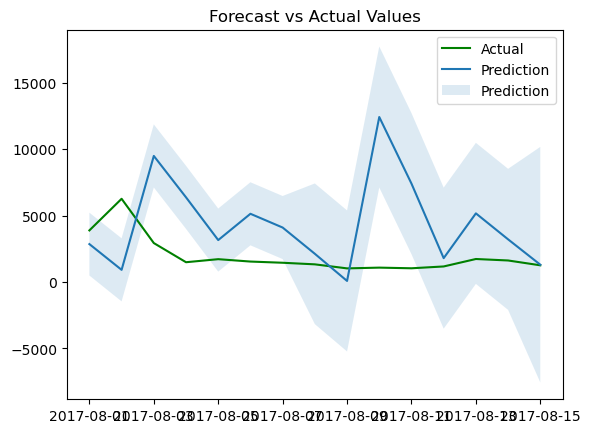


Diagnostics of model:



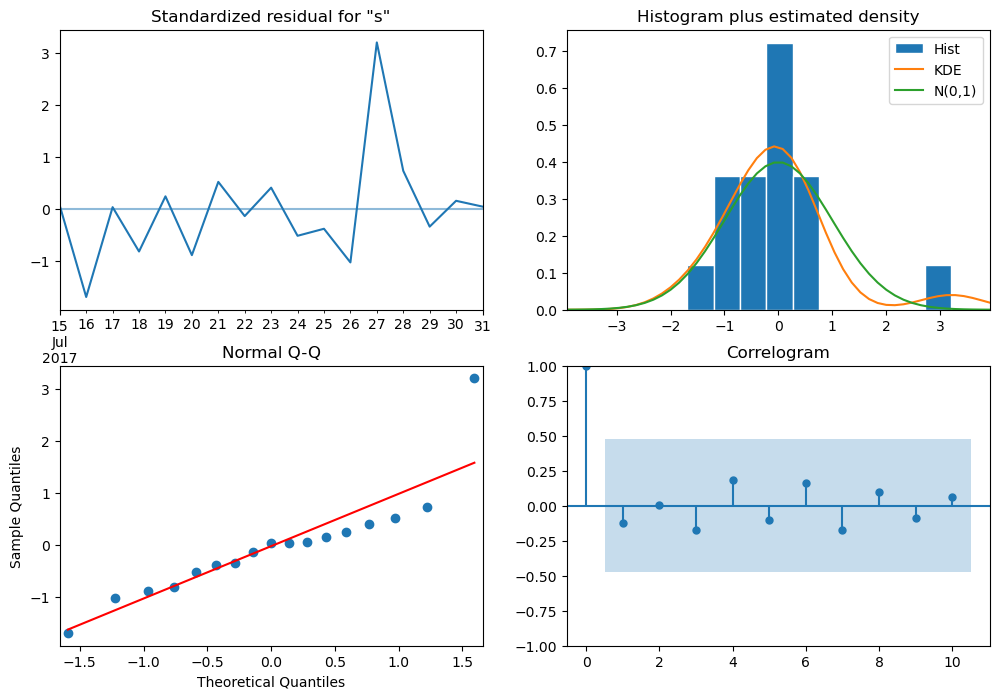

In [92]:
store_nbr = 39
family = 'CLEANING'
plot_results_specific_sarimax_model(store_nbr, family)

For this model we can same the same from the other model, but for this one is even worse the forecasting compared with the actual values, and for the Q-Q plot shows more deviations from the straight line.

<a id='evaluationSARIMAX'></a>
#### Evaluation for test set Kaggle

In [ ]:
%%time
store_list = a_final_eval.store_nbr.sort_values().unique()
family_group = a_final_eval.family.sort_values().unique()
kaggle_results =  pd.DataFrame()
exog_features = ['onpromotion', 'dcoilwtico','is_local_hol_or_eve','is_regional_hol_or_eve','is_national_hol_or_eve','day_of_week']
df_train_tmp = train_df[train_df.date >= '2017-08-01']
i = 0
for store_nbr in store_list:
    for family in family_group:
        model = str(store_nbr) + "_" + family
        df_train_tmp_2 = df_train_tmp[(df_train_tmp.store_nbr == store_nbr) & (df_train_tmp.family == family)]
        df_test_tmp = test_df[(test_df.store_nbr == store_nbr) & (test_df.family == family)]
        df_august = pd.concat([df_train_tmp_2,df_test_tmp]) #Need to have historical data to get predictions
        forecast = models_sarimax_month[model].get_prediction(start=pd.to_datetime('2017-08-16').date(),end= pd.to_datetime('2017-08-31').date(), exog=df_august[exog_features])
        tmp_results = df_test_tmp.merge(forecast.predicted_mean, left_on = 'date', right_index = True, how = 'left')[['id','predicted_mean']]
        kaggle_results = pd.concat([kaggle_results, tmp_results])
        # counter of iterations
        i+=1
        if i%100 == 0:
            print(i)

kaggle_results = kaggle_results.rename(columns={"predicted_mean": "sales"}).sort_values(by='id')
today = str(date.today())
kaggle_results.to_csv('submission_sarimax_{date}.csv'.format(date=today), index=False)  
print(kaggle_results.head())

<a id='PROPHET'></a>
### Prophet by Facebook 

Prophet could be a good fit for our data because this model takes into account:
- **Trends**: Automatically detects linear or non-linear trends.
- **Seasonality**: Daily, weekly, or yearly recurring patterns are automatically identified.
- **Holidays**: You can explicitly define holidays or use a method for taking into account the holidays of specific country.
- **External features**: Can be added into the model as external 'regressors'.
  
Prophet is designed for **ease of use**. You simply provide your historical data with timestamps and (optionally) holiday information. Check [here](https://medium.com/illumination/understanding-fb-prophet-a-time-series-forecasting-algorithm-c998bc52ca10) for more information about the prophet model.

For hardware and time performance limitations, data must be partitioned and trained a separately different sarimax models for every partition. These partitions will be done with every combination of store number and family product.

In the next cell, you can see a traning and a scoring function. In the training function a prophet model is trained for each combination of store and family product. For the scoring function, MAE, R2 and RMSLE are calculated for each model and then a general MAE,R2 and RMSLE are calculated.

At first, we'll try to fit data with a monthly historical range and then we'll use the year of historical dataframe.

In [45]:
def train_multiple_prophet_models(df_train, file_path):
    models_prophet = {}
    # Transform dataset to meet prophet model requirements    
    prophet_df = df_train[['date','store_nbr','family','sales','onpromotion', 'dcoilwtico','is_local_hol_or_eve','is_regional_hol_or_eve','is_national_hol_or_eve','day_of_week','day_of_month','month','week']].rename(columns={"date": "ds","sales":"y"})
    
    store_list = prophet_df.store_nbr.sort_values().unique()
    family_group = prophet_df.family.sort_values().unique()
    # For each combination of store and family, train a model
    for store in store_list:
        for family in family_group:
            model_name = str(store) + "_" + family
            df_train_tmp = prophet_df[(prophet_df.store_nbr == store) & (prophet_df.family == family)]
            model = Prophet(interval_width=0.95, weekly_seasonality=True)
            model.add_country_holidays(country_name='EC')
            model.add_regressor('onpromotion')
            model.add_regressor('dcoilwtico')
            model.add_regressor('is_local_hol_or_eve')
            model.add_regressor('is_regional_hol_or_eve')
            model.add_regressor('is_national_hol_or_eve')
            model.add_regressor('day_of_week')
            model.add_regressor('day_of_month')
            model.add_regressor('month')
            model.add_regressor('week')

            model.fit(df_train_tmp)
            models_prophet[model_name] = model

    # Open the file in binary mode
    with open(file_path, 'wb') as file:
        # Serialize and write the variable to the file
        pickle.dump(models_prophet, file)

    return models_prophet  

def prophet_metric_errors(models_prophet, df_test):
    # Initializate lists to store results
    forecast_values = [] 
    real_values = [] 
    r2_values = []
    mae_values = []
    models_name = []
    rmsle_values = []

    # Prepate dataset for prophet model
    prophet_test_df = df_test[['date', 'store_nbr','family','onpromotion', 'dcoilwtico','is_local_hol_or_eve','is_regional_hol_or_eve','is_national_hol_or_eve','sales','day_of_week','day_of_month','month','week']].rename(columns={"date": "ds"})
     
    store_list = prophet_test_df.store_nbr.sort_values().unique()
    family_group = prophet_test_df.family.sort_values().unique()
    
    for store in store_list:
        for family in family_group:
            model = str(store) + "_" + family
            if model in models_prophet.keys():
                df_test_tmp = prophet_test_df[(prophet_test_df.store_nbr == store) & (prophet_test_df.family == family)]
                forecast = models_prophet[model].predict(df_test_tmp.drop(columns=['sales','family','store_nbr']))
                actual_values = df_test_tmp['sales'].values
                future_predicted_values = forecast['yhat'].values
                # Append all forecast and real values for general metric errors
                forecast_values.extend(future_predicted_values)
                real_values.extend(actual_values)
        
                # Calculate error metrics for each specific model
                models_name.append(model)
                r2_scr = r2_score(actual_values,future_predicted_values)
                # Because r2 is not lower bounded, for visualizig purposes set 0 all those negative r2 scores.
                if r2_scr <= 0:
                    r2_scr = 0
                r2_values.append(r2_scr)
                mae_values.append(mean_absolute_error(actual_values,future_predicted_values))
                future_predicted_values = [0 if i < 0 else i for i in future_predicted_values] #Mean Squared Logarithmic Error cannot be used when targets contain negative values.
                rmsle_values.append(sqrt(mean_squared_log_error(actual_values,future_predicted_values)))
                
    data = {
        'r2': r2_values,
        'mae': mae_values,
        'rmsle': rmsle_values
    }
    df = pd.DataFrame(data, index=models_name)
    # create histogram with a different y scale for different rows
    selection = ['r2', 'mae','rmsle']
    fig, axes = plt.subplots(nrows=1, ncols=3,  figsize=(14,4))
    for i, col in enumerate(selection):
        ax = sns.histplot(data=df, x=col, ax=axes.flatten()[i], bins = 50)
        ax.set_ylabel('value')
        ax.set_xlabel(col)
    plt.show()
    
    # General metrics
    r2 = r2_score(real_values,forecast_values)
    print("\nGeneral value for R2 metric for all models is: " + str(r2))
    mae = mean_absolute_error(real_values,forecast_values)
    print("\nGeneral value for MAE metric for all models is:" + str(mae))
    forecast_values = [0 if i < 0 else i for i in forecast_values] #Mean Squared Logarithmic Error cannot be used when targets contain negative values.
    rmsle = sqrt(mean_squared_log_error(real_values,forecast_values))
    print("\nGeneral value for RMSLE  metric for all models is:" + str(rmsle))
    
    return r2, mae, rmsle, df

<a id='ProphetMonth'></a>
#### Monthly historical data

Train the model or load trained model from disk.

In [21]:
%%time 
#18min
file_path = 'prophet_month_trained.pickle'
# models_prophet_month = train_multiple_prophet_models(df_train_month, file_path)
with open(file_path, 'rb') as file:
    # Deserialize and retrieve the variable from the file
    models_prophet_month = pickle.load(file)

CPU times: total: 3.16 s
Wall time: 3.36 s


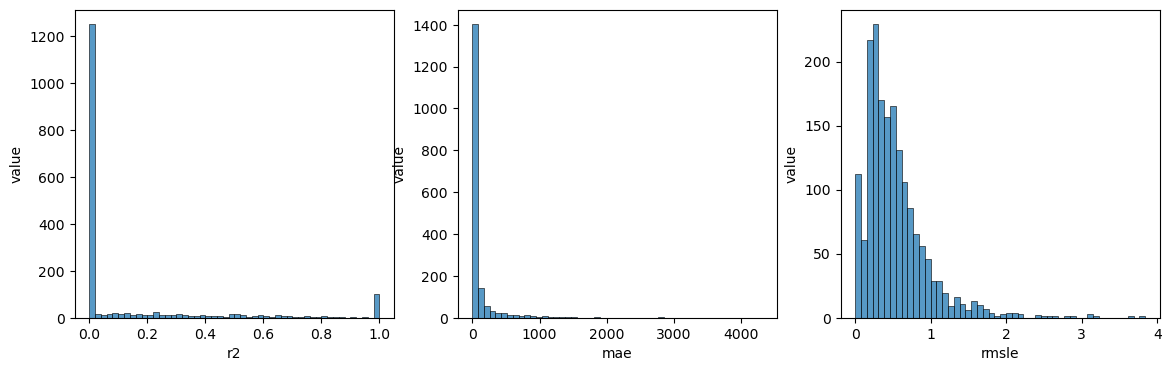


General value for R2 metric for all models is: 0.8816669327734493

General value for MAE metric for all models is:118.25362231809567

General value for RMSLE  metric for all models is:0.6792065122691611
CPU times: total: 3min 33s
Wall time: 3min 33s


In [22]:
%%time 
r2_prophet_month, mae_prophet_month, rmsle_prophet_month, all_models_metric_prophet_month = prophet_metric_errors(models_prophet_month, df_test)

In [23]:
new_row = pd.DataFrame({'MAE': [mae_prophet_month], 'R2': [r2_prophet_month], 'RMSLE': [rmsle_prophet_month]}, index=['Prophet trained month data'])
df_results = pd.concat([df_results, new_row])

Let's check the prediction of the same models plot in the Sarimax section:

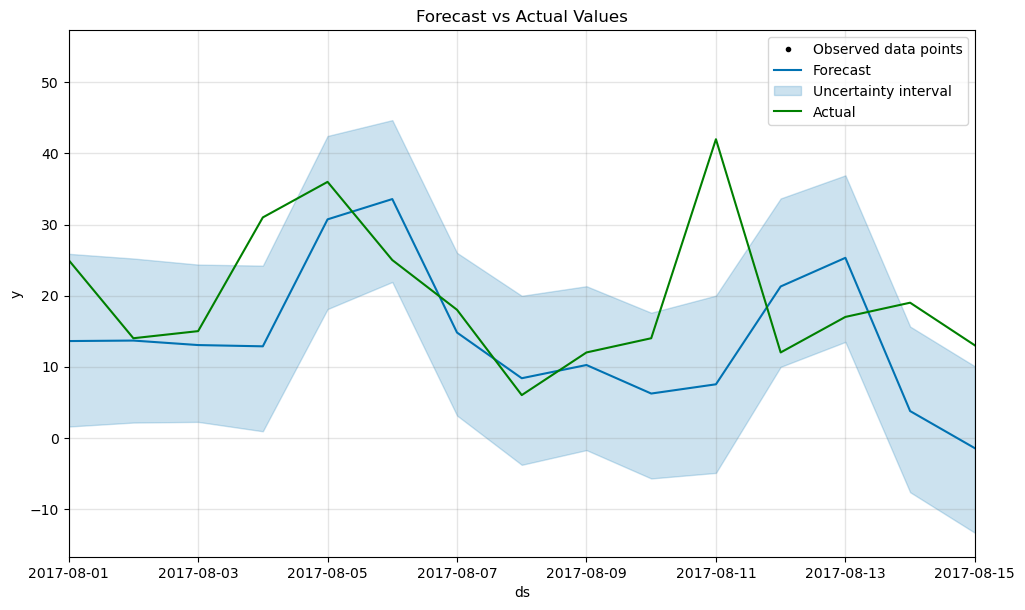

In [55]:
def plot_prophet_forecast_vs_actual_values(df, models, store, family):
    tmp = df[(df.store_nbr == store) & (df.family == family)][['date', 'store_nbr','family','onpromotion', 'dcoilwtico','is_local_hol_or_eve','is_regional_hol_or_eve','is_national_hol_or_eve','sales','day_of_week','day_of_month','month','week']].rename(columns={"date": "ds"})
    model  = models[str(store) + "_" + family]
    future = model.make_future_dataframe(periods=12)
    forecast = model.predict(tmp)
    fig1 = model.plot(forecast)
    plt.plot(tmp['sales'], label = 'Actual', color = 'green')
    plt.title('Forecast vs Actual Values')
    ax = plt.gca()
    x_min_lim = tmp.ds.min()
    x_max_lim = tmp.ds.max()
    ax.set_xlim([x_min_lim, x_max_lim])
    plt.legend()
    plt.show()

store = 28
family = 'HOME AND KITCHEN II'
plot_prophet_forecast_vs_actual_values(df_test, models_prophet_month, store, family)

With this model we obtain similar results to sarimax forecast.

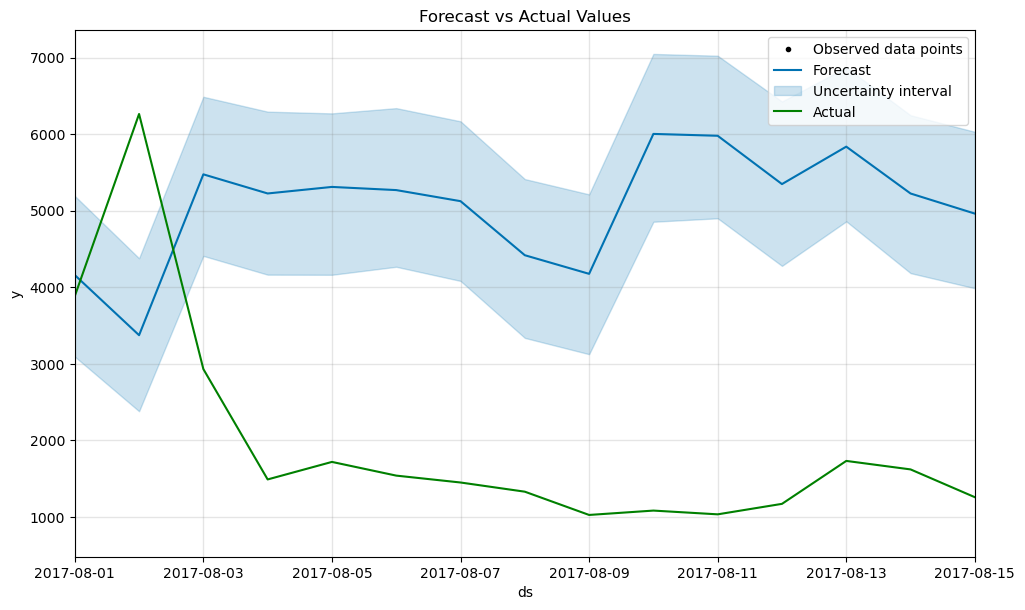

In [110]:
store = 39
family = 'CLEANING'
plot_prophet_forecast_vs_actual_values(df_test, models_prophet_month, store, family)

This model is performing way worst than the sarimax forecast.

<a id='ProphetYear'></a>
#### Year historical data

Train the model or load trained model from disk.

In [46]:
%%time 
#19 min
file_path = 'prophet_year_trained2.pickle'
# models_prophet_year = train_multiple_prophet_models(df_train_year, file_path)
with open(file_path, 'rb') as file:
    # Deserialize and retrieve the variable from the file
    models_prophet_year = pickle.load(file)

CPU times: total: 12min 4s
Wall time: 19min 17s


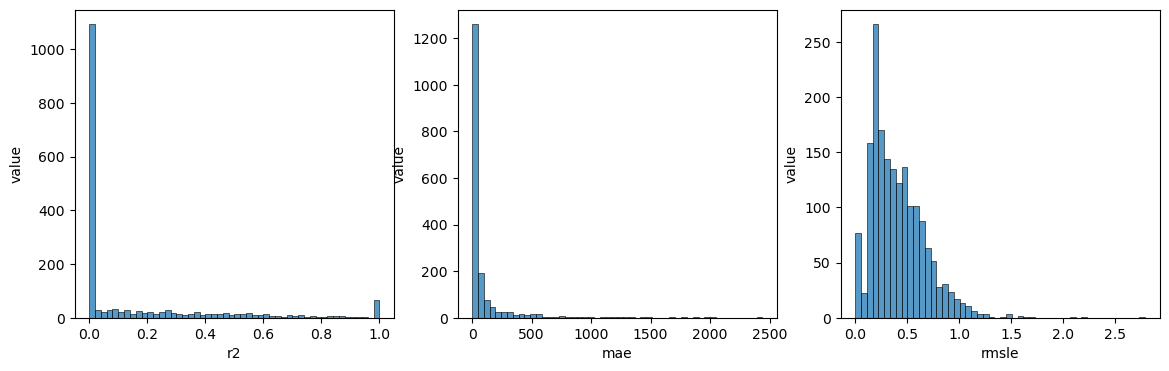


General value for R2 metric for all models is: 0.9415668276669995

General value for MAE metric for all models is:90.74235849878538

General value for RMSLE  metric for all models is:0.4886493013308016
CPU times: total: 4min 13s
Wall time: 4min 16s


In [47]:
%%time
r2_prophet_year, mae_prophet_year, rmsle_prophet_year, all_models_metric_prophet_year = prophet_metric_errors(models_prophet_year, df_test)

In [26]:
new_row = pd.DataFrame({'MAE': [mae_prophet_year], 'R2': [r2_prophet_year], 'RMSLE': [rmsle_prophet_year]}, index=['Prophet2 trained year data'])
df_results = pd.concat([df_results, new_row])

As you can see, we get the **best results so far**. This also can be seen in the graphs below, which are the same time series plots than in sarimax and in monthly prophet version. With this model, the forecasting is more similar to actual values than in the other models. 

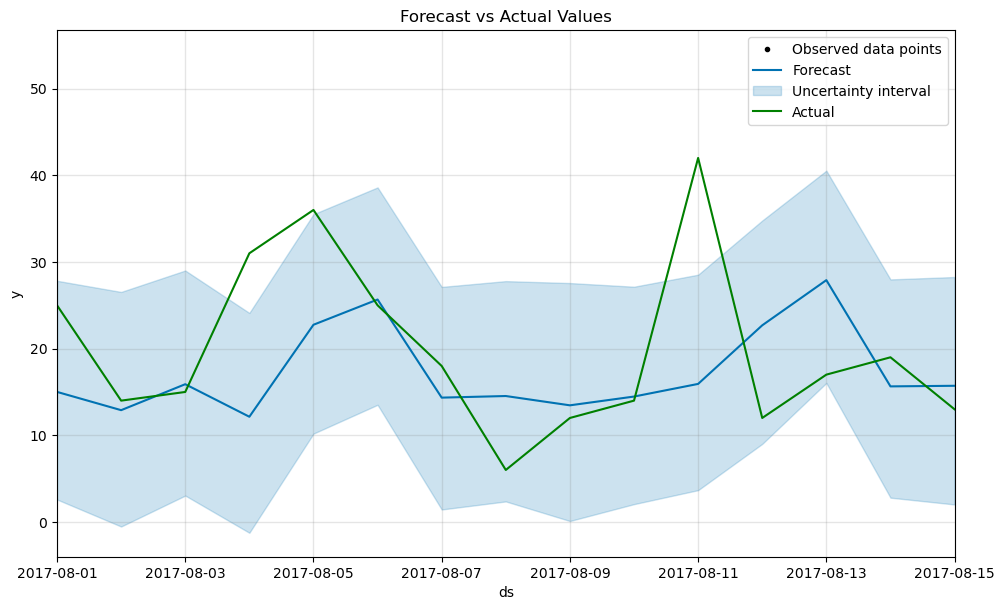

In [56]:
store = 28
family = 'HOME AND KITCHEN II'
plot_prophet_forecast_vs_actual_values(df_test, models_prophet_year, store, family)

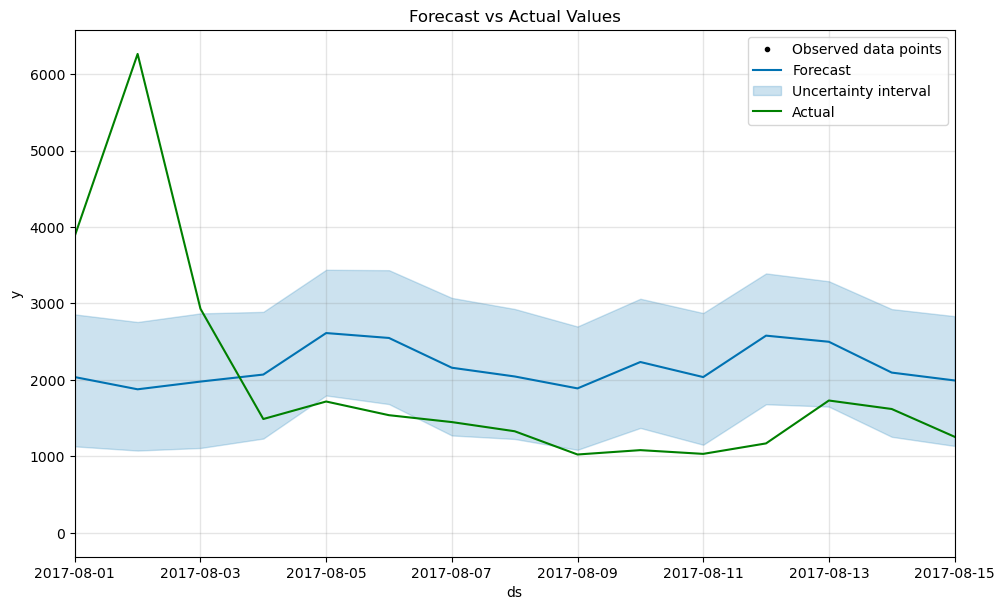

In [57]:
store = 39
family = 'CLEANING'
plot_prophet_forecast_vs_actual_values(df_test, models_prophet_year, store, family)

<a id='evaluationProphet'></a>
#### Evaluation for test set Kaggle

In [58]:
%%time
y_prediction = []
ids = []
a_final_eval = test_df.rename(columns={"date": "ds"})

store_list = a_final_eval.store_nbr.sort_values().unique()
family_group = a_final_eval.family.sort_values().unique()

for store in store_list:
    for family in family_group:
        tmp = a_final_eval[(a_final_eval.store_nbr == store) & (a_final_eval.family == family)]
        if tmp.size > 0:
            model = str(store) + "_" + family
            forecast = models_prophet_year[model].predict(tmp)
            y_prediction.extend(forecast['yhat'].values)
            ids.extend(tmp.id.values)

kaggle_results = pd.DataFrame({'id': ids, 'sales': y_prediction}).sort_values(by='id')
kaggle_results[kaggle_results.sales < 0]['sales'] = 0 # Negative results don't make sense in terms of sales
from datetime import date
today = str(date.today())
kaggle_results.to_csv('submission_prophet_{date}.csv'.format(date = today), index=False) 

CPU times: total: 3min 57s
Wall time: 3min 59s


<a id='XGBoost'></a>
### XGBoost

ML models could be a good fit for our data because also can take into account seasonality components and also exogenous (i.e. external) variables can be added to the model.

Xgboost model is a type of model made of **multiple decision trees**, actually is an ensemble of two types of model: a weak one and strong one. This model is made in an iterative way: in each step the weak model (which is a tree) is trained to predict the error of the strong one and then this weak model is added to the strong one to reduce its the error in each iteration.

In tree algorithms, the value of the feature does not matter, but the order of the values, that's why in these models the standardization of the data is not necessary and in this section we won't standardize the data. They are robust to noisy data, have interpretable properties and are well suited for training on small datasets, or on datasets where the ratio of number of features / number of examples is high.

This model can be used for forecasting. The core idea is to leverage past observations to predict future values. You can add **lagged versions of your target variable as features**. For example, to predict sales next day, you can include features like sales from the previous days.

To train the xgboost model, what I've done is the following:
1. First, train the basic xgboost (with cross validation) with different lagged values and get the number of lagged values that lead the best error metrics.
2. Secondly, train with cross validation and hyperparameter tunning the model with the best metric error from the previous step.


For the scoring function, MAE, RMSLE and R2 is calculated for each model and then a general MAE, RMSLE and R2 is calculated.

At first, we'll try to fit data with a monthly historical range and then we'll use the year of historical dataframe.

In [27]:
# Feature engineering to add lagged values for the sales feature in the dataset

def create_lag_features(group,total_lags):
    for lag in range(1,total_lags+1):
        key  = 'sales_lag_' + str(lag)
        group[key] = group['sales'].shift(lag)
    return group

def create_lag_values_sales(df,total_lags, features = ['date','store_nbr','family','onpromotion', 'dcoilwtico','is_local_hol_or_eve','is_regional_hol_or_eve','is_national_hol_or_eve','sales','day_of_week','day_of_month','month','week']):
    df_tmp = df.copy()
    df_tmp = df_tmp[features]

    # Sort the DataFrame by date to ensure proper alignment
    df_tmp.sort_values(by=['store_nbr', 'family', 'date'], inplace=True)

    # Apply the function to each group formed by 'family' and 'store_nbr'
    df_lagged = df_tmp.groupby(['family', 'store_nbr']).apply(create_lag_features, total_lags = total_lags)
    
    # Drop rows with NaN resulting from lagged values
    df_lagged.dropna(inplace=True)

    df_lagged.drop(columns=['date'], inplace=True)
    return df_lagged
    
def custom_preprocessing(df, total_lags, features = ['date','store_nbr','family','onpromotion', 'dcoilwtico','is_local_hol_or_eve','is_regional_hol_or_eve','is_national_hol_or_eve','sales','day_of_week','day_of_month','month','week']):
    df_tmp = df.copy()
    return pd.get_dummies(create_lag_values_sales(df_tmp,total_lags,features), columns=['family'])


In [28]:
# Get the best model with differents number of lagged values 

def metrics_error_for_different_lagged_values_xgb(df_train, df_test, features =  ['date','store_nbr','family','onpromotion', 'dcoilwtico','is_local_hol_or_eve','is_regional_hol_or_eve','is_national_hol_or_eve','sales','day_of_week','day_of_month','month','week']):
    # Create dt to store results
    grid_search_lagged_values_xgb =  pd.DataFrame()
    testing_values_xgb =  pd.DataFrame()

    # Prepare train data
    df_train_xgboost = df_train.copy()
    df_train_xgboost.index = df_train_xgboost.id
    df_train_xgboost.drop(columns = ['id'], inplace = True)
    # Prepare test data
    df_test_xgboost = df_test.copy()
    df_test_xgboost.index = df_test_xgboost.id
    df_test_xgboost.drop(columns = ['id'], inplace = True)
    
    for total_lagged_values in [1,7,14,21,28,30]:
    
        ## Define RMSLE custom scorer
        def rmsle(y_true, y_pred):
            return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))
    
        ## Tranform training and testing data
        df_train_xgboost_tmp = custom_preprocessing(df_train_xgboost, total_lagged_values, features)
        df_train_xgboost_tmp_X = df_train_xgboost_tmp.drop(columns=['sales'])
        df_train_xgboost_tmp_y = df_train_xgboost_tmp['sales']
        df_test_tmp = pd.concat([df_train_xgboost,df_test_xgboost])
        df_test_tmp = custom_preprocessing(df_test_tmp, total_lagged_values, features)
        df_test_xgboost_tmp = df_test_tmp[df_test_tmp.index.isin(df_test_xgboost.index)]
        df_test_dt_X = df_test_xgboost_tmp.drop(columns=['sales'])
        df_test_dt_y = df_test_xgboost_tmp['sales']
    
        ## Define the model and the cross validation settings
        xgb_model = xgb.XGBRegressor(objective='reg:squaredlogerror')
        # Define the number of folds for cross-validation
        n_folds = 5
        # Define custom scoring functions for different metrics
        scoring = {
            'mae': make_scorer(mean_absolute_error),
            'r2': make_scorer(r2_score),
            'rmsle': make_scorer(rmsle, greater_is_better=False)
        }
        # Perform KFold cross-validation
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
        # Perform cross-validation and calculate multiple metrics
        mae_scores = cross_val_score(xgb_model, df_train_xgboost_tmp_X, df_train_xgboost_tmp_y, scoring=scoring['mae'], cv=kf)
        r2_scores = cross_val_score(xgb_model, df_train_xgboost_tmp_X, df_train_xgboost_tmp_y, scoring=scoring['r2'], cv=kf)
        # For RMSLE, we need to use custom scoring and handle predictions with log transformation
        rmsle_scores = cross_val_score(xgb_model, df_train_xgboost_tmp_X, df_train_xgboost_tmp_y, scoring=scoring['rmsle'], cv=kf)
        rmsle_scores = -rmsle_scores  # Convert negative scores to positive (RMSLE should be minimized)
        # Get the mean of all cross validations sets
        mae = np.mean(mae_scores)
        r2 = np.mean(r2_scores)
        rmsle = np.mean(rmsle_scores)
        # Save cross validating score
        new_row = pd.DataFrame({'MAE': [mae], 'R2': [r2], 'RMSLE': [rmsle]}, index=['XGBoost trained month data with {} lagged values'.format(total_lagged_values)])
        grid_search_lagged_values_xgb = pd.concat([grid_search_lagged_values_xgb, new_row])
    
        ## Train model and apply it to test data
        xgb_model.fit(df_train_xgboost_tmp_X, df_train_xgboost_tmp_y)
        pred_xgb = xgb_model.predict(df_test_dt_X)
        # Get testing score
        mae = mean_absolute_error(df_test_dt_y, pred_xgb)
        r2 = r2_score(df_test_dt_y, pred_xgb)
        pred_xgb = [0 if i < 0 else i for i in pred_xgb] #Mean Squared Logarithmic Error cannot be used when targets contain negative values.
        rmsle = sqrt(mean_squared_log_error(df_test_dt_y, pred_xgb))
        # Save testing score
        new_row = pd.DataFrame({'MAE': [mae], 'R2': [r2], 'RMSLE': [rmsle]}, index=['XGBoost trained month data with {} lagged values'.format(total_lagged_values)])
        testing_values_xgb = pd.concat([testing_values_xgb, new_row])

    return grid_search_lagged_values_xgb, testing_values_xgb
    

In [38]:
#Train xgboost model for forecasting

def tune_hyperparameters_xgb_with_specific_lagged_values(df_train, df_test, number_of_lagged_values, features = ['date','store_nbr','family','onpromotion', 'dcoilwtico','is_local_hol_or_eve','is_regional_hol_or_eve','is_national_hol_or_eve','sales','day_of_week','day_of_month','month','week']):
    # Prepate data
    df_train_xgb = df_train.copy()
    df_train_xgb.index = df_train_xgb.id
    df_test_xgb = df_test.copy()
    df_test_xgb.index = df_test_xgb.id
    # Apply feature engineering
    df_train_xgb = pd.get_dummies(create_lag_values_sales(df_train_xgb,number_of_lagged_values), columns=['family'])
    df_test_xgb = pd.get_dummies(create_lag_values_sales(df_test_xgb,number_of_lagged_values), columns=['family'])
    # Split target and features
    df_train_xgb_X = df_train_xgb.drop(columns=['sales'])
    df_train_xgb_y = df_train_xgb['sales']
    df_test_xgb_X = df_test_xgb.drop(columns=['sales'])
    df_test_xgb_y = df_test_xgb['sales']  

    # Define grid search and cross validation settings
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    params_grid_xgb = {
        'n_estimators' : [25,50,100],
        'max_depth': [2,3,4,5,6,7], #Control overfitting
        'colsample_bytree': [0.25, 0.5, 1], #Control overfitting
        'min_child_weight': [1,10,100], #Control overfitting
        'gamma': [1,10,100] #Control overfitting
    }
# {'colsample_bytree': 1, 'gamma': 1, 'max_depth': 7, 'min_child_weight': 10, 'n_estimators': 100} a year
# {'colsample_bytree': 1, 'gamma': 1, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 100} month
    
    xgb = XGBRegressor(n_jobs= -1)
    # Fit xgb
    grid_xgb = GridSearchCV(xgb, params_grid_xgb, n_jobs=-1, cv=kf, verbose=1, scoring=['neg_mean_squared_error'], refit='neg_mean_squared_error')
    grid_xgb.fit(df_train_xgb_X,df_train_xgb_y)
    print("Best params:\n")
    print(grid_xgb.best_params_)
    # Predict and get eval metrics
    pred_grid_pipeline_xgb = grid_xgb.predict(df_test_xgb_X)
    mae = mean_absolute_error(df_test_xgb_y, pred_grid_pipeline_xgb)
    r2 = r2_score(df_test_xgb_y, pred_grid_pipeline_xgb)
    pred_grid_pipeline_xgb = [0 if i < 0 else i for i in pred_grid_pipeline_xgb] #Mean Squared Logarithmic Error cannot be used when targets contain negative values.
    rmsle = sqrt(mean_squared_log_error(df_test_xgb_y, pred_grid_pipeline_xgb))

    return grid_xgb, r2, mae, rmsle  

<a id='XgboostMonth'></a>
#### Monthly historical data

For training Xboost, let's find out how many lagged values should we add to our data. So, at first we'll search for the best base model with different combinations of lagged values, and then we'll improve that model by tunning the hyperparameters.

In [35]:
%%time 
features = ['date','store_nbr','family','onpromotion', 'dcoilwtico','is_local_hol_or_eve','is_regional_hol_or_eve','is_national_hol_or_eve','sales','day_of_week']
cross_validation_errors, testing_errors = metrics_error_for_different_lagged_values_xgb(df_train_month, df_test, features)

CPU times: total: 0 ns
Wall time: 0 ns


In [35]:
cross_validation_errors

,MAE,R2,RMSLE
XGBoost trained month data with 1 lagged values,379.926313,0.045549,0.877013
XGBoost trained month data with 7 lagged values,377.266000,0.043180,0.865436
XGBoost trained month data with 14 lagged values,388.200446,0.027624,0.900591
XGBoost trained month data with 21 lagged values,409.465604,-0.003164,0.996473
XGBoost trained month data with 28 lagged values,503.715511,-0.051668,1.232517
XGBoost trained month data with 30 lagged values,452.422905,-0.079092,1.392749


In [36]:
testing_errors

,MAE,R2,RMSLE
XGBoost trained month data with 1 lagged values,358.867476,0.068387,0.840346
XGBoost trained month data with 7 lagged values,358.043647,0.065853,0.822166
XGBoost trained month data with 14 lagged values,367.868547,0.044603,0.875653
XGBoost trained month data with 21 lagged values,376.955882,0.019534,0.936229
XGBoost trained month data with 28 lagged values,400.109432,-0.028804,1.137628
XGBoost trained month data with 30 lagged values,414.914269,-0.064671,1.281433


As we can see in the cross validation and testing scores, we get the best error metric when we're using 7 lagged values. So, we'll tune the xgb model with 7 lagged values:


In [36]:
%%time
total_lagged_values = 7
xgb_trained, r2_xgb, mae_xgb, rmsle_xgb = tune_hyperparameters_xgb_with_specific_lagged_values(df_train_month, df_test, total_lagged_values, features)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best params:

{'colsample_bytree': 1, 'gamma': 1, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 100}
CPU times: total: 19.1 s
Wall time: 21.5 s


In [37]:
new_row = pd.DataFrame({'MAE': [mae_xgb], 'R2': [r2_xgb], 'RMSLE': [rmsle_xgb]}, index=['XGBoost trained monthly data with {} lagged values'.format(total_lagged_values)])
df_results = pd.concat([df_results, new_row])

<a id='XgboostYear'></a>
#### Year historical data

As we've done previously, we'll find out how many lagged values as input features works the best for xgboost using training data for the last year

In [59]:
%%time 
cross_validation_errors, testing_errors = metrics_error_for_different_lagged_values_xgb(df_train_year, df_test)

CPU times: total: 1h 45min 10s
Wall time: 20min 54s


In [60]:
cross_validation_errors

,MAE,R2,RMSLE
XGBoost trained month data with 1 lagged values,300.266802,0.227350,0.700534
XGBoost trained month data with 7 lagged values,293.679030,0.262843,0.684930
XGBoost trained month data with 14 lagged values,276.669584,0.270898,0.611705
XGBoost trained month data with 21 lagged values,285.295382,0.268672,0.670663
XGBoost trained month data with 28 lagged values,285.681328,0.253169,0.623490
XGBoost trained month data with 30 lagged values,287.399887,0.249947,0.626406


In [61]:
testing_errors

,MAE,R2,RMSLE
XGBoost trained month data with 1 lagged values,287.066683,0.357177,0.671237
XGBoost trained month data with 7 lagged values,293.658663,0.351584,0.775386
XGBoost trained month data with 14 lagged values,248.344843,0.400040,0.514936
XGBoost trained month data with 21 lagged values,292.675255,0.318560,0.801010
XGBoost trained month data with 28 lagged values,292.462246,0.239424,0.592876
XGBoost trained month data with 30 lagged values,281.620008,0.287207,0.565661


As we can see in the cross validation and testing scores, we get the best error metric when we're using 14 lagged values. So, we'll tune the xgb model with 14 lagged values:

In [39]:
%%time
total_lagged_values = 14
xgb_trained_year, r2_xgb, mae_xgb, rmsle_xgb = tune_hyperparameters_xgb_with_specific_lagged_values(df_train_year, df_test, total_lagged_values)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best params:

{'colsample_bytree': 1, 'gamma': 1, 'max_depth': 7, 'min_child_weight': 10, 'n_estimators': 100}
CPU times: total: 1min 14s
Wall time: 1min 6s


In [40]:
new_row = pd.DataFrame({'MAE': [mae_xgb], 'R2': [r2_xgb], 'RMSLE': [rmsle_xgb]}, index=['XGBoost trained year data with {} lagged values'.format(total_lagged_values)])
df_results = pd.concat([df_results, new_row])

In [25]:
# save the year xgb model as a pickle file
xgb_year_file = "xgb_year.pickle"  
with open(xgb_year_file, 'wb') as file:  
    pickle.dump(xgb_trained_year, file)


<a id='evaluationXgboost'></a>
#### Evaluation for test set Kaggle

In [49]:
%%time

model = xgb_trained_year
test_df_tmp = test_df.copy()
dates_historical_forecast = test_df_tmp.date.unique()
historical_df = train_df[train_df.date >= (min(dates_historical_forecast) - np.timedelta64(total_lagged_values,'D'))]

prediction = []
ids = []

for date in sorted(dates_historical_forecast):
    # Retrieve historical data (or forecasted) to get lagges valued for this specific date
    subset_historical_df = historical_df[historical_df.date >= (date - np.timedelta64(total_lagged_values,'D'))]
    
    # Retrieve data from date to forecast
    test_df_tmp_2 = test_df_tmp[test_df_tmp.date == date]
    # Add dummy sales columns
    test_df_tmp_2['sales'] = -1
    
    # Union subset historical dataset with dataset with date to forecast
    tmp_df = pd.concat([subset_historical_df, test_df_tmp_2], ignore_index=False)
    tmp_df.index = tmp_df.id
    
    # Create lagged values for date to forecast dataset
    tmp_df = custom_preprocessing(tmp_df,total_lagged_values)

    #Make prediction
    pred_xgboost = model.predict(tmp_df.drop(columns=["sales"]))

    # Add forecast to historical subset 
    forecast_df = pd.DataFrame({'sales': pred_xgboost}, index = tmp_df.index)
    test_df_tmp_2 = test_df_tmp_2.drop(columns=['sales']).merge(forecast_df, left_on='id', how='left', right_index=True)
    historical_df = pd.concat([historical_df, test_df_tmp_2], ignore_index=True)

# Save results
kaggle_results = historical_df[historical_df.date >= '2017-08-16'][['id','sales']].sort_values(by='id')
kaggle_results[kaggle_results.sales < 0]['sales'] = 0 # Negative results don't make sense in terms of sales
from datetime import date
today = str(date.today())
kaggle_results.to_csv('submission_xgb_{date}.csv'.format(date=today), index=False)  
print(kaggle_results.head())

            id        sales
24948  3000888     2.461220
24949  3000889     0.970379
24950  3000890     2.857556
24951  3000891  2178.364014
24952  3000892     0.970379
CPU times: total: 3min 35s
Wall time: 3min 24s


<a id='COMPARISON'></a>

## Model comparison
As you can see in the next cell, there are all the performance results for each model we've tried to fit to our data. Our main metrics have been the MAE, R2 and RMSLE so we'll sort the results by RSMLE, which is the same metric evaluation for the Kaggle project: 

In [43]:
df_results.sort_values(by = 'RMSLE')

,MAE,R2,RMSLE
XGBoost2 trained year data with 14 lagged values,47.627658,0.978860,0.467023
Prophet trained year data,82.317945,0.947267,0.489487
Sarimax trained month data,106.060052,0.909375,0.621541
XGBoost trained monthly data with 7 lagged values,68.357731,0.959250,0.621748
Prophet trained month data,118.253622,0.881667,0.679207


As we can see above, we obtain the best results by training yearly data. Our best results are with the xgboost and prophet models. Let's submit a prediction of each of them at the kaggle competition and let's see which score we get with both of them.

- **Results from Xgboost:**
  ![results_xgboost_kaggle.png](results_xgboost_kaggle.png)
  
- **Results from Prophet:**
  ![results_prophet_kaggle.png](results_prophet_kaggle.png)
  
As we can see above, both models performed worse than our test set. This could mean that there are overfitting in both models. On the other hand, specially the Xgboost performed worse than the prophet. This could be due to the fact that for xgboost we've used 14 lagged values and our window to forecast was about 15 days, so we've used forecasted values to predict also future values. For example, for the 15th day to predict, we haven't used any historical data, only predicted values, then, we may be carrying forward prediction errors that in turn affect the prediction of future values.

To sum up, we can say that out **best model has been Prophet** trained with 1 year of data.

<a id='PRODUCTION'></a>
# To production

To recap, what we have done so far is analyze the dataset of the sales of Favorita Stores, and we have created a model capable of predicting the future sales based on the features of the dataset. Now, we are going to leverage this model and truly see the value that this work will bring us.

To do so, we'll predict the forecasting values for the future sales for every family product and store, and also we'll get the upper and the lower bound of sales with a 95% of confidence:

In [ ]:
%%time
y_prediction = []
y_lower = []
y_upper = []
ids = []
a_final_eval = test_df.rename(columns={"date": "ds"})

store_list = a_final_eval.store_nbr.sort_values().unique()
family_group = a_final_eval.family.sort_values().unique()

i = 0

for store in store_list:
    for family in family_group:
        tmp = a_final_eval[(a_final_eval.store_nbr == store) & (a_final_eval.family == family)]
        if tmp.size > 0:
            model = str(store) + "_" + family
            forecast = models_prophet_year[model].predict(tmp)
            y_prediction.extend(forecast['yhat'].values)
            y_lower.extend(forecast['yhat_lower'].values)
            y_upper.extend(forecast['yhat_upper'].values)
            ids.extend(tmp.id.values)
        i+=1
        if i%100 == 0:
            print(i)

kaggle_results = pd.DataFrame({'id': ids, 'sales': y_prediction, 'lower_sales': y_lower, 'upper_sales': y_upper}).sort_values(by='id')
print(kaggle_results.head())

In [ ]:
looker = test_df.merge(kaggle_results, left_on='id', how='left', right_on = 'id')
looker['sales'] = looker['sales'].apply(lambda x: round(x, 3))
looker['lower_sales'] = looker['lower_sales'].apply(lambda x: round(x, 3))
looker['upper_sales'] = looker['upper_sales'].apply(lambda x: round(x, 3))
looker

In [ ]:
looker.to_csv('looker_report.csv', index=False)  

An important part of an ML project is being able to make the trained model available for other teams or colleagues of the company to take advantage of the insights they can get of it. One technical way could be creating an API that our colleagues could make their own predictions. Another approach it could be to present the results in an interactive report and enable anyone with the link to get their own insights.

That's why I've created an example of a [report](https://lookerstudio.google.com/s/svVPttPBqWI) that we could create with the results of the model:


In [5]:
from IPython.display import IFrame, HTML
ulr= 'https://lookerstudio.google.com/embed/reporting/a787fb72-8e31-49d8-978a-c9ee525fda36/page/BKLvD'
IFrame(ulr, width='100%', height=500)

<a id='improvements'></a>
# Future improvements

1. Check for outliers
2. Try sarimax with anual year (problem: high training time) 
3. Try deep learning model
4. Try prophet hyperparameter and cross validation (problem: high training time) 

In [ ]:
# %%time

# # Hyperparameter and cross validation with Prophet
# from prophet.diagnostics import cross_validation
# from prophet.diagnostics import performance_metrics
# import itertools
# import numpy as np
# import pandas as pd

# param_grid = {  
#     'changepoint_prior_scale': [0.001, 0.1],
#     'seasonality_prior_scale': [0.01, 0.1],
#     'seasonality_mode': ['additive', 'multiplicative'],
# }

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# maes = []  # Store the MAEs for each params here

# prophet_df = df_train_year[['date','store_nbr','family','sales','onpromotion', 'dcoilwtico','is_local_hol_or_eve','is_regional_hol_or_eve','is_national_hol_or_eve','day_of_week', 'day_of_month', 'month' ,'week']].rename(columns={"date": "ds","sales":"y"})
# df_train_tmp = prophet_df[(prophet_df.store_nbr == 15) & (prophet_df.family == 'BEVERAGES')]

# # Use cross validation to evaluate all parameters
# for params in all_params:
#     # m = Prophet(**params).fit(df)  # Fit model with given params
#     model = Prophet(interval_width=0.95, weekly_seasonality=True,**params)
#     model.add_country_holidays(country_name='EC')
#     model.add_regressor('onpromotion')
#     model.add_regressor('dcoilwtico')
#     model.add_regressor('is_local_hol_or_eve')
#     model.add_regressor('is_regional_hol_or_eve')
#     model.add_regressor('is_national_hol_or_eve')
#     model.add_regressor('day_of_week')
#     model.add_regressor('day_of_month')
#     model.add_regressor('month')
#     model.add_regressor('week')
#     model.fit(df_train_tmp)
    
#     df_cv = cross_validation(model, horizon='30 days', parallel="processes")
#     df_p = performance_metrics(df_cv)
#     maes.append(df_p['mae'].values[0])

# # Find the best parameters
# tuning_results = pd.DataFrame(all_params)
# tuning_results['mae'] = maes
# print(tuning_results)